In [30]:
import requests
import timeit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import pandas as pd
from matplotlib.patches import Ellipse
from scipy.stats import moment as sigma
from scipy import constants
from copy import copy
import os

In [31]:
plt.rcParams.update(plt.rcParamsDefault)

In [32]:
REQUEST_URL = "http://0.0.0.0:8000/" 
# REQUEST_URL = "http://black/astra/"
REQUEST_HEADERS = {'Content-Type': 'application/json', 'x-api-key': os.getenv("ASTRA_API_KEY")}

def request(endpoint, data):
    return requests.post(REQUEST_URL + endpoint, headers=REQUEST_HEADERS, json=data)

# Requesting data

In [55]:
generator_parameters = { 
    "particle_count": 10000, 
    "time_spread": False,
    "dist_z": "gauss",
    "sig_Ekin": 1.5,
    "Nemit_x": 1.0E0,
    "sig_y": 0.75E0,
    "Nemit_y": 1.0E0,
    "C_sig_z": 2.0,
    "sig_z": 1.0E0,
    "sig_x":0.75E0,
    "Ref_Ekin":2.0E0,
}

In [56]:
response = request("generate", generator_parameters)
response.status_code

200

In [57]:
raw_data = response.json()
print(raw_data.keys())
data = pd.DataFrame(raw_data['particles'])
data

dict_keys(['timestamp', 'particles', 'input_ini'])


,x,y,z,px,py,pz,clock,macro_charge,particle_index,status_flag
0,0.000000,0.000000,0.000000,0.000000,0.000000,2.458457e+06,0.0,-0.0001,1,5
1,0.000375,0.000000,0.000500,0.000000,0.000000,0.000000e+00,0.0,-0.0001,1,3
2,0.000000,0.000375,-0.000500,0.000000,0.000000,0.000000e+00,0.0,-0.0001,1,3
3,0.000750,0.000000,0.001000,0.000000,0.000000,0.000000e+00,0.0,-0.0001,1,3
4,0.000000,0.000750,-0.001000,0.000000,0.000000,0.000000e+00,0.0,-0.0001,1,3
...,...,...,...,...,...,...,...,...,...,...
9995,-0.000230,0.000200,0.001039,720.628222,790.297436,-5.024867e+02,0.0,-0.0001,1,5
9996,-0.000349,0.000053,0.000387,489.305531,425.467807,4.740510e+02,0.0,-0.0001,1,5
9997,-0.000478,-0.000092,-0.000124,304.346705,156.163781,-1.788604e+03,0.0,-0.0001,1,5
9998,-0.000622,-0.000241,-0.000672,139.755321,-89.950328,2.307884e+03,0.0,-0.0001,1,5


In [59]:
print(raw_data['input_ini'])

&INPUT
    Add = false
    N_add = 0
    IPart = 10000
    Species = 'electrons'
    Probe = true
    Noise_reduc = true
    Q_total = 1.0
    Cathode = false
    High_res = true
    Ref_zpos = 0.0
    Dist_z = 'gaussian'
    Dist_pz = 'gauss'
    Dist_x = 'gauss'
    Dist_px = 'gauss'
    Dist_y = 'gauss'
    Dist_py = 'gauss'
    cor_Ekin = 0.0
    cor_px = 0.0
    cor_py = 0.0
    Ref_Ekin = 2.0
    sig_Ekin = 1.5
    sig_x = 0.75
    sig_y = 0.75
    sig_z = 1.0
    C_sig_z = 2.0
    Nemit_x = 1.0
    Nemit_y = 1.0
    FNAME = '/app/data/generator/1707304330.31866.ini'
/


In [60]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

In [61]:
x = data.loc[:, 'x'].values*1e3
y = data.loc[:, 'y'].values*1e3
z = data.loc[:, 'z'].values*1e3
px = data.loc[:, 'px'].values
py = data.loc[:, 'py'].values
pz = data.loc[:, 'pz'].values

# Views

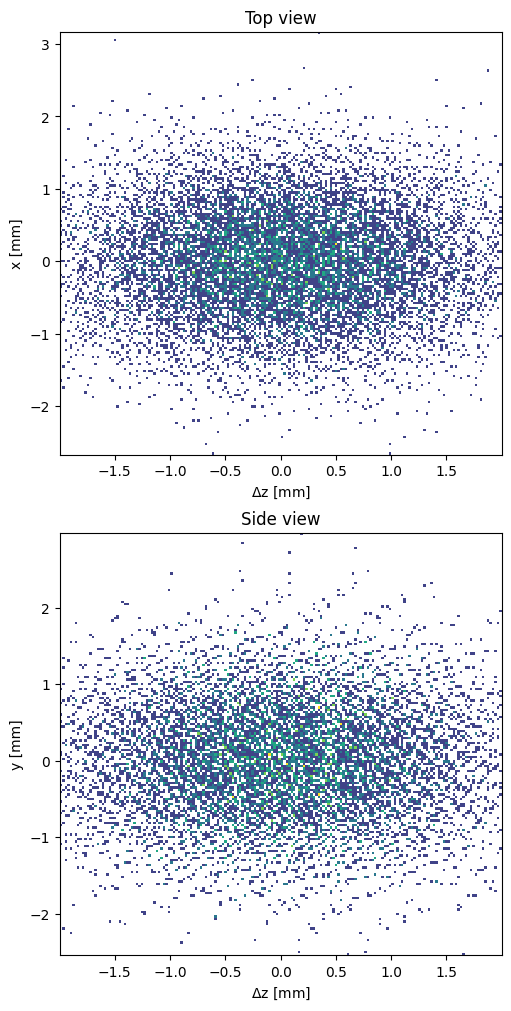

In [62]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(5, 10), constrained_layout=True)

ax_1.hist2d(z, x, (180, 180), cmap=white_viridis)
ax_1.title.set_text('Top view')
ax_1.set_xlabel(r'$\Delta$z [mm]'); ax_1.set_ylabel('x [mm]')

ax_2.hist2d(z, y, (180, 180), cmap=white_viridis)
ax_2.title.set_text('Side view')
ax_2.set_xlabel(r'$\Delta$z [mm]'); ax_2.set_ylabel('y [mm]')

# fig.delaxes(ax_4)

plt.show()

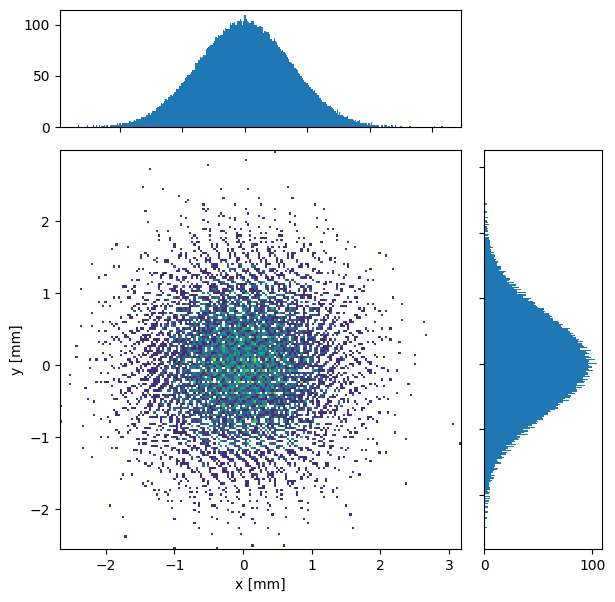

In [63]:
fig = plt.figure(figsize=(7, 7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_joint.hist2d(x, y, (180, 180), cmap=white_viridis)
ax_joint.set_xlabel('x [mm]'); ax_joint.set_ylabel('y [mm]')

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])
ax_marg_x.hist(x, bins=300)
ax_marg_y.hist(y, bins=300, orientation="horizontal")

plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

plt.show()

# Transverse phase spaces

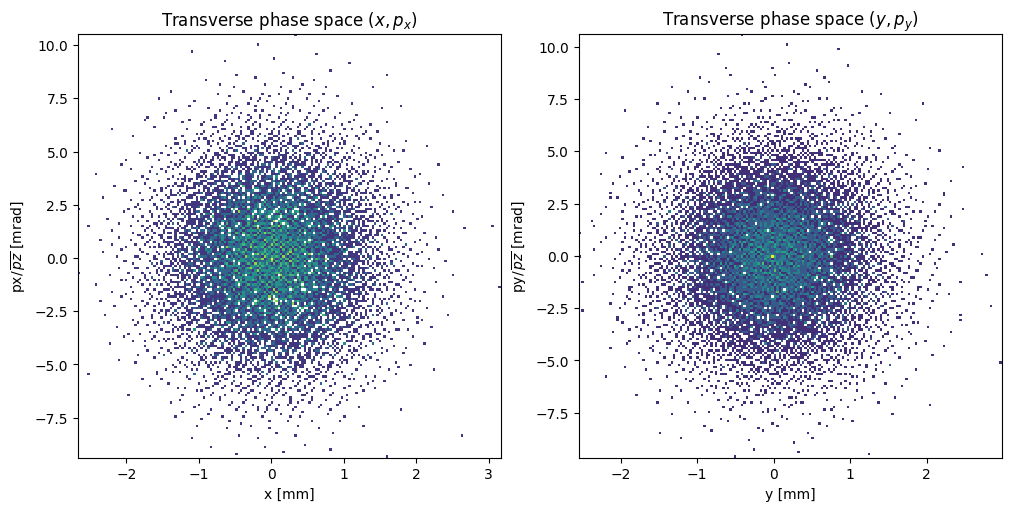

In [64]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

fwhm = 2 * np.sqrt(2 * np.log(2))

ax_1.hist2d(x, px/np.mean(pz), (180, 180), cmap=white_viridis)
ax_1.title.set_text(r'Transverse phase space $(x, p_x)$')
ax_1.set_xlabel('x [mm]'); ax_1.set_ylabel(r'px/$\,\overline{pz}$ [mrad]')

# ellipse_fwhm = Ellipse((np.mean(x), np.mean(px)/np.mean(pz)), 2*fwhm*np.std(x), 2*fwhm*np.std(px/np.mean(pz)), edgecolor='red', fc='None', lw=1)     
# ax_1.add_patch(ellipse_fwhm)

ax_2.hist2d(y, py/np.mean(pz), (180, 180), cmap=white_viridis)
ax_2.title.set_text(r'Transverse phase space $(y, p_y)$')
ax_2.set_xlabel('y [mm]'); ax_2.set_ylabel(r'py/$\,\overline{pz}$ [mrad]')

# ellipse_fwhm = Ellipse((np.mean(y), np.mean(py)/np.mean(pz)), 2*fwhm*np.std(y), 2*fwhm*np.std(py/np.mean(pzdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA/MAAAH/CAYAAAAboY3xAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAACvjklEQVR4nO3deZgU1fU38O+AMIDsiCAwrK6oiKAoJgoKCUrEJQYVF1ARNyACLhGjiJiIikHcxZ8RJIoa8rrFGKOgYCK4gQuoqBARZBMXGMAwLNPvH3h7qm+fvn1vdVV3Vc/38zw8ka6qW7eqe6j0nHPPKUkkEgkQERERERERUWzUKPQEiIiIiIiIiMgNv8wTERERERERxQy/zBMRERERERHFDL/MExEREREREcUMv8wTERERERERxQy/zBMRERERERHFDL/MExEREREREcUMv8wTERERERERxQy/zBMRERERERHFDL/MExEREREREcUMv8wTEREREVVj48ePR0lJCb799ttCT4UA3HHHHTjwwANRWVlZ6Klk9NBDD6Ft27aoqKgo9FSqNX6ZJyJf+OCPFj74iSgqSkpKrP7MnTu30FMlipzy8nLcfvvt+N3vfocaNaL7Ve2CCy7A9u3bMXXq1EJPpVrbo9ATIAJ2P/htvP766+jdu3e4kyGKGfXgv/POOyP/4B8/fjymTp2K3/72t4WeDhGF5C9/+UvK32fMmIFXX3017fWDDjoon9MiioVHH30UO3fuxKBBgwo9FaM6depgyJAhmDx5MkaOHGn9/+UpWPwyT5HABz+Rf3zwE1GUnHfeeSl/f+utt/Dqq6+mvZ7J1q1bseeee4YxtUgo9uuj3EybNg2nnHIK6tSpU+ipZHXmmWfijjvuwOuvv44TTjih0NOplqIbwqFq5bzzzkv5s//++4uvt2jRQjx+69at+Zxu3hX79VFu4vbg/+qrr/D6668XeipEFAFqydYnn3yCc845B02aNMHPf/5zfPXVV7jiiitwwAEHoG7dumjWrBkGDhyIFStWZBxj2bJluOCCC9C4cWM0atQIF154IX788cfkfps3b8aoUaPQvn17lJaWYu+998YvfvELLFq0CADwt7/9DSUlJZg3b17aOaZOnYqSkhIsWbIk+drq1atx0UUXoUWLFigtLcXBBx+MRx991Or6bOZje45s93bp0qU488wz0bBhQzRr1gxXXnkltm3bJh6zceNG4z20fV9sri2X67MZ3+X6XT5vq1evxtChQ9GqVSuUlpaiQ4cOuPzyy7F9+/acr+vLL7/ERx99hL59+6Zt69+/P9q3b5/2eiKRQLdu3XDsscdmHV855ZRT0L17d8ycORNdu3ZF3bp10b59e9x1113WYwBA9+7d0bRpUzz//PNOx1Fw+GWeYocPfj74+eCvYnrwr169GnXq1MFFF12U8vrs2bNRq1YtjB49Ouv4Ch/8RBSmgQMH4scff8Stt96KYcOG4d1338X8+fNx9tln45577sFll12GOXPmoHfv3inPGK8zzzwTmzdvxsSJE3HmmWdi+vTpuPnmm5PbL7vsMjz44IM444wz8MADD+Dqq69G3bp18emnnwIAfvWrX6F+/fr461//mjb2008/jYMPPhiHHHIIAGD9+vU4+uijMXv2bIwYMQJ333039t13XwwdOhRTpkzJen0283E9RyZnnnkmtm3bhokTJ6J///645557cMkll/i6h7bvS7Zry/X6bMZ3uX7b61qzZg169OiBp556CmeddRbuuecenH/++Zg3b15yv1yua/78+QCAbt26pW078sgj8dVXX+GHH35Ief2pp57C+++/j9tuu804ttfixYuxatUqjBgxAqeccgruvPNONGnSBGPGjME//vEP63HUXN98802nYyhACaIIGj58eCLTx/Omm25KAEh07tw5ceqppyYeeOCBxP3335+YNWtW4rDDDkuMGzcu8fDDDyeuv/76RJMmTRLt2rVLbN26VRzj8MMPT/z6179OPPDAA4mLL744ASBx7bXXJvc755xzErVr106MGTMm8cgjjyRuv/32xIABAxKPP/54IpFIJH788cdE/fr1E1dccUXaPI8//vjEwQcfnPz7unXrEm3atEmUlZUlJkyYkHjwwQcTp5xySgJA4q677sp6fTbzsT1HJurchx56aGLAgAGJ++67L3HeeeclACTOP/98X/fQ9n3Jdm25Xp/N+C7Xb3tdq1evTrRq1SpRr169xKhRoxIPPfRQ4sYbb0wcdNBBiR9++CHn63r88ccTABIfffSRuH348OGJWrVqJVasWJFIJBKJTz/9NNG4cePEgAEDErt27TKO7dW+fftE8+bNE02aNEnceOONifvuuy/RtWvXBIDEiy++aD1OIpFI9O3bN9G9e3enY4govmye6YMGDUp5/ccff0zbd8GCBQkAiRkzZohjXHTRRSmvn3766YlmzZol/96oUaPE8OHDjXMdNGhQYu+9907s3Lkz+dratWsTNWrUSEyYMCH52tChQxP77LNP4ttvv005/uyzz040atQoOf9M12czH9tzZKLOfcopp6S8fsUVVyQAJD788MO0fbPdQ9v3xeZe53J9NuO7XL/tdQ0ePDhRo0aNxLvvvpu2f2VlZc7XdcMNNyQAJDZv3py27YUXXkgASMyZMyf52vbt2xOdOnVKDBgwIOOYuvLy8kRJSUmiYcOGiU8//TT5+jfffJOoW7eu+Fk1ueSSSxJ169Z1OoaCwy/zFEl88PPBH/T1VccHfyKRSHz99deJ0tLSxOWXX5749ttvE506dUp07do1sWXLloxj6vjgJ6Jc2DzT582bl/H47du3J7799tvEhg0bEo0bN06MGjVKHOOdd95JeX3y5MkJAIlNmzYlEolEol27dokjjjgisXr16ozneu655xIAErNnz06+du+99yYAJD777LNEIrH73+7GjRsnLrnkksSGDRtS/kybNi0BIPGf//wn6/WZ5uNyjkzUuf/1r3+lvP7pp58mACQmTpzofA+9TO9Ltnud6/XZvJcu129zXbt27Uo0bNgwceqpp2Y8Z67Xdfnllyf22GMPcdvatWsTABKTJk1KvnbfffclatSokVi8eHHGMXXq/6vceuutadu6deuW+PnPf249ViKRSPzud79LAEgLnFF+MM2eYuuyyy5L+XvdunWT/71jxw5899132HfffdG4ceO0VO1MYxx77LH47rvvUF5eDgBo3Lgx3n77baxZsybjPM466yx88803KS12/va3v6GyshJnnXUWgN3rmf7f//t/GDBgABKJBL799tvkn379+mHTpk1pc9Tnlm0+fs6RyfDhw1P+PnLkSADASy+9lLZvtnto+75ku9e5Xp/Ne6nYXL/NdVVWVuK5557DgAEDcMQRR6Sdp6SkJOfr+u6777DHHnugfv364vbWrVtj2LBhePTRR/GrX/0K//vf//Diiy86FV/6+OOPkUgkcN111+HAAw9Mvt68eXMcdNBBWLVqlfVYANCkSRP873//y5gqS0TVT4cOHVL+/r///Q/jxo1DWVkZSktLsddee6F58+bYuHEjNm3aJI7Rtm3blL83adIEAJJpyXfccQeWLFmCsrIy9OjRA+PHj8d///vflGNOPPFENGrUCE8//XTytaeffhpdu3ZN1vPZsGEDNm7ciIcffhjNmzdP+XPhhRcCAL755hvj9WWbj59zZLLffvul/L1Tp06oUaOGuCws2z20fV+y3etcr8/mvXS5fpvr2rBhA8rLy5NLLSRBvm+6li1bonXr1nj//fcB7K6ndMstt+C8884zzkm3ePFiAMD5558vbnctzphIJADYd6aiYLGaPcWW9OCfOHEipk2bhtWrVyf/cQHg68HfsGFD3HHHHRgyZAjKysrQvXt39O/fH4MHD0bHjh2Tx3gf/H369AFgfvA//PDD4lxsH/yZ5uPnHJkE9eBv2LCh9fuS7V7nen0276XL9dtcl+uDP9f3LZOrr74a9913Hz766CP8+9//RuvWrZ2O54OfiMLm/QUpsPuXqNOmTcOoUaPQs2dPNGrUCCUlJTj77LNRWVkpjlGzZk3xdfVvzplnnoljjz0Wzz77LF555RVMmjQJt99+O5555hmcdNJJAIDS0lKcdtppePbZZ/HAAw9g/fr1ePPNN3Hrrbcmx1PnP++88zBkyBDxnF26dDFeX7b5HH744c7nsGX6tzfbPbR9X7Ldaz/30MvmvXS5fj+fN0mu19WsWTPs3LkTmzdvRoMGDdK2H3nkkckv85MnT8YPP/yACRMmWM8PAJYsWYKmTZuiTZs2Ka9v27YNn3zySTKAYeuHH35AvXr1xM84hY9f5im2+ODng9/l+qrrgx8A/vjHPwIAdu7ciaZNm1rPTeGDn4jy7W9/+xuGDBmCP/3pT8nXtm3bho0bN+Y07j777IMrrrgCV1xxBb755ht069YNf/zjH1OeA2eddRYee+wxzJkzB59++ikSiUQy0w7YnZXUoEED7Nq1Syw+GsR85s2bF9g5vvjii5QAwbJly1BZWSlWRs/G5X0x3esg7qHNewnYXb/NdTVv3hwNGzZMKWysy/W6VPbbl19+KT77jzzySLzwwgtYuXIl7rzzTlx++eVo166d0zkWL14s/n+3adOmYdu2bTjjjDMAAN9//z323ntvlJeXo169egB2B6seeOCBlMLPX375JVtHFxC/zFPR4IOfD/5squODf9KkSXjkkUdw33334ZprrsEf//hHPPLII07nsH3wA8CIESOwY8cOTJ06FZWVlTj99NPRsWPHlKr3fPATUTY1a9ZMyXgCgHvvvRe7du3yNd6uXbuwZcsWNGrUKPna3nvvjVatWqGioiJl3759+6Jp06Z4+umn8emnn6JHjx4pz4SaNWvijDPOwMyZM7FkyZK07KsNGzagefPmOc0niHMo999/P375y18m/37vvfcCQNZfZEts3hebe53L9bm8l4Dd9dtcV40aNXDaaafh8ccfx3vvvZe2fC6RSOT8vvXs2RMA8N5774nP9COOOAKVlZU455xzkEgk8Pvf/z7jWJksWbIEGzZswBdffJHMRNywYQMmTpyIfv364aijjgIANG3aFGVlZfjoo49w9NFHY+fOnRg3blxap51Fixbh3HPPdZ4HBYNf5qlo8MHPBz8f/KkP/ueeew7XXXcdbrnlFgwfPhxffPEFHnjgAfz+978Xl3FkYvvgB4CxY8eic+fOGDduHCZPnoxEIpHyCw+AD34iyu7kk0/GX/7yFzRq1AidO3fGggULMHv2bDRr1szXeJs3b0abNm3wm9/8Bocddhjq16+P2bNn49133037N6pWrVr49a9/jaeeegpbt27FnXfemTbebbfdhtdffx1HHXUUhg0bhs6dO+P777/HokWLMHv2bHz//fc5zyfXcyhffvklTjnlFJx44olYsGABHn/8cZxzzjk47LDDLO9eFZv3xfZe+70+l/fS9vptP2+33norXnnlFfTq1QuXXHIJDjroIKxduxazZs3Cf/7zHzRu3Din961jx4445JBDMHv27LS2sgCS/z/izTffxPjx4zP+/4OSkhL06tUrpZ4TsLtt3oYNG9ClSxecfPLJGD58OP73v//h/vvvx65du9K+qB9xxBF4//33cfTRR2P69Ono1KkTfvaznyW3L1y4EN9//z1OPfXUjNdE4eKXeSoafPDzwc8Hf9WDf+HChTj33HNx7rnnJn9zf+211+Khhx4So/NBPfhbt26N888/HyeffDIA4D//+Q9q1KiqtcoHPxHZuPvuu1GzZk088cQT2LZtG372s59h9uzZ6Nevn6/x6tWrhyuuuAKvvPIKnnnmGVRWVmLffffFAw88gMsvvzxt/7POOguPPPIISkpKcOaZZ6Ztb9GiBd555x1MmDABzzzzDB544AE0a9YMBx98MG6//fZA5pPrOZSnn34a48aNw3XXXYc99tgDI0aMwKRJk6yP97J5X2zvtd/rc30vba7f9vPWunVrvP3227jxxhvxxBNPoLy8HK1bt8ZJJ52UTEXP9X276KKLMG7cOPzvf/9LW47WtGlTtG/fHlu3bsVVV10lHr9lyxYAu7MRdaoGziOPPIKHH34Y48aNQyKRwEknnYRJkyahVatWKfurL/MVFRW45ZZb8Oyzz6ZsnzVrFtq2bYsTTjgh63VRSPJQMZ/ImU0bmw0bNqS8/sMPPyQuvPDCxF577ZWoX79+ol+/fomlS5cm2rVrlxgyZIjVGKptyJdffpmoqKhIXHPNNYnDDjss0aBBg8See+6ZOOywwxIPPPCAOK9XX301ASBRUlKSWLVqlbjP+vXrE8OHD0+UlZUlatWqlWjZsmWiT58+iYcffjjr3GznY3OOTNS5P/nkk8RvfvObRIMGDRJNmjRJjBgxIvG///3P+R4mEnbvi8u99nN9tuO7XL/L5+2rr75KDB48ONG8efNEaWlpomPHjonhw4cnKioqcrouZfLkyYn69esnW9itWrUqsc8++yR+9rOfJbZt25ay7+WXX56oVatW4r///W/ytc2bNycAJM4+++y0sdXn+p133klcfPHFiUaNGiUaNmyYOOussxIrV64U5/Pwww8nACTmz5+ftu13v/tdom3btsm2fEREFI5Mz+nqIq7Xv3HjxkTTpk0TjzzySNq25cuXJ2rWrJm4++67Mx7/j3/8I1FSUpL46KOP0rbdddddiZo1a6b9f4NMZs+enTjiiCMSd911V+KMM85I2bZt27ZEy5YtE1OmTLEai8LBL/NElBTXB19Q4nr9pge/jSAf/G+99VaiTZs2iTPOOCNx6aWXpmzjg5+IKH/i+kwLSpyv/7bbbksccMABiV27dqW8fuaZZyY6deqUEgzQXX311YlBgwaJ2y666KLEfvvtZz2PH374IVG3bt1Ey5YtEx9//HHKtgcffDBRVlZm/f8PKBzsM09EFHONGjXCtddei0mTJjlV0ldef/11nH322Tj00EPTti1evBgdO3ZEaWlp1nFWrlyJgQMH4vHHH8fdd9+NmTNnYuXKlcnt06ZNQ61atXDZZZc5z5GIiKi6+N3vfoelS5eiRo0a2LhxI5588klceumlmDVrFu6//37Url0747GTJk3CzJkzxW1LlixxKkDbuHFjtGrVCr/4xS/QuXPnlG2XXXYZVq5cafX/Dyg8/DJPRFQEvA9+V0E8+Ddv3oyTTz4ZN910E3r16oXWrVvj3HPPTWnRyAc/ERGRmzlz5uCcc87BSy+9hKlTp/quG5FIJPDxxx87fZnfsmULtm7divHjx/s6J4WvJJHQyjETUbU1fvx43HzzzdiwYQP22muvQk8n76r79esSiQQaNGiAESNG4Lbbbiv0dIiIiCiPRo8ejV27duGee+4p9FQoA36ZJyIiIiIiIgDABx98gF69euGII47A888/j/r16xd6SpQBv8wTERERERERxQzXzBMRERERERHFzB6FnkAcVVZWYs2aNWjQoAFKSkoKPR0iIiIkEgls3rwZrVq18lUIsbriM52IiKLG9pnOL/M+rFmzBmVlZYWeBhERUZpVq1ahTZs2hZ5GbPCZTkREUZXtmc4v8z40aNAAwO6b27BhwwLPhqj4nHzCxOR/v/ja2ALOhCg+ysvLUVZWlnxGkR0+0ykqTv7ZeADAi2+OL+g8iKjwbJ/p/DLvg0rDa9iwIR/8RCF4472J2XciIhFTxd3wmU5R8cbiyYWeAhFFTLZnOhfVEREREREREcUMv8wTERERERERxQy/zBMRERERERHFDL/MExEREREREcVMpL/Mv/HGGxgwYABatWqFkpISPPfccynbE4kExo0bh3322Qd169ZF37598cUXX2Qd9/7770f79u1Rp04dHHXUUXjnnXdCugIiIiIiIiKi4EX6y/zWrVtx2GGH4f777xe333HHHbjnnnvw0EMP4e2338aee+6Jfv36Ydu2bRnHfPrppzFmzBjcdNNNWLRoEQ477DD069cP33zzTViXQURERERERBSoSH+ZP+mkk/CHP/wBp59+etq2RCKBKVOm4IYbbsCpp56KLl26YMaMGVizZk1aBN9r8uTJGDZsGC688EJ07twZDz30EOrVq4dHH300xCshiq4Tjh6PE44eX+hpEFGRY7YdUfE5oetYnNB1bKGnQVRtRfrLvMmXX36JdevWoW/fvsnXGjVqhKOOOgoLFiwQj9m+fTsWLlyYckyNGjXQt2/fjMcAQEVFBcrLy1P+EBERkT1m2xEREQUrtl/m161bBwBo0aJFyustWrRIbtN9++232LVrl9MxADBx4kQ0atQo+aesrCzH2RMREVUvzLYjIiIKVmy/zOfT2LFjsWnTpuSfVatWFXpKRIF57a3xeO2t8YWeBhFVY8y2I4qn1z6YiNc+mFjoaRBVW7H9Mt+yZUsAwPr161NeX79+fXKbbq+99kLNmjWdjgGA0tJSNGzYMOUPERERBYPZdkRERO5i+2W+Q4cOaNmyJebMmZN8rby8HG+//TZ69uwpHlO7dm1079495ZjKykrMmTMn4zFERERUPJhtR0QSVcyPBf0oTvYo9ARMtmzZgmXLliX//uWXX+KDDz5A06ZN0bZtW4waNQp/+MMfsN9++6FDhw648cYb0apVK5x22mnJY/r06YPTTz8dI0aMAACMGTMGQ4YMwRFHHIEePXpgypQp2Lp1Ky688MJ8Xx4REREhNdtun332Sb6+fv16dO3aVTwml2y70tLS3CdNRERUYJH+Mv/ee+/h+OOPT/59zJgxAIAhQ4Zg+vTpuPbaa7F161Zccskl2LhxI37+85/j5ZdfRp06dZLHLF++HN9++23y72eddRY2bNiAcePGYd26dejatStefvnltDQ9Kn6qHRvXixMRFZY32059eVfZdpdffrl4jDfbTv0SX2XbqV/gExHZ4tp/iqNIf5nv3bs3EolExu0lJSWYMGECJkyYkHGfFStWpL02YsQIPuiJiIjyiNl2REREwYr0l3kiIiIqDsy2IyIiClZJwhT6JlF5eTkaNWqETZs2sbI9UUyoZRUAl1ZQceKzyR/eN7LlLYzGlGwiCpPtsym21eyJiIiIiIiIqium2RNRtcBoPBER5YLReCKKGkbmiYiIiIiIiGKGX+aJKCcnHD0+ZT06ERERERGFj1/miYiIiIiIiGKGX+aJiIiIiIiIYoYF8IgKSKWnx7k4W5znTkREREQUV4zMExEREREREcUMI/NEBcSodvXiLRTI956IiIrFCV3HAmD7PqJ8Y2SeiIiIiIiIKGYYmSciyhNG44mIqBhVp4g8sxAoShiZJyIiIiIiIooZfpknIiIiIiIiihmm2RMRERER5Siu6ddq3kD85l4IvEcUJYzMExEREREREcUMI/NERAZsJ0dERDbiGrGN47zjmgVBFDRG5omIiIiIiIhihl/miYiIiIiIiGKGafZEFLo4p6rHbb5ERETFjun1RLsxMk9EREREREQUM4zME8UEo9sUFvXZ4vtERBScOLZ8Y2E5onhhZJ6IiIiIiIgoZkoSiUSi0JOIm/LycjRq1AibNm1Cw4YNCz0dImdRjfIzQkzkH59N/vC+FT9Gm6uXOGZEEOlsn02MzBMRERERERHFDL/MExEREREREcUM0+x9YEpe9cZU8Hjh+0XVBZ9N/vC+ERFR1DDNnoiIiIiIiKhIsTUdkSNGeOOF7xcREWVTrEXyivW6XPE+ULFiZJ6IiIiIiIgoZrhm3geuryM/4rh2O4pzjmpbPaJC47PJH943osJjOzmiVFwzT0RERERERFSk+GWeiIiIiIiIKGaYZu8DU/Ion6KY6m4rjnOP45yVOM+dcsdnkz+8b/nHYmT5F8c0dn5OqDpjmj0RERERERFRkWJk3gf+Fp8o/xh1JjLjs8kf3jeKMkaniaonRuaJiIiIiIiIitQehZ4AkQ1GZc3i3K7Ndu5xuy4iIgpHdYpW69cYp7Xv1el9ssH7QWFgZJ6IiIiIiIgoZvhlnoiIiIiIiChmWADPBxbLIRdxWyIQRMp+oa7Z79zjvEyBSOGzyR/eNyqEOKXLB6U6XnNYmLJf/KpNAbz27dujpKQk7c/w4cPF/adPn562b506dfI8ayIiIiIiIiL/Yh+Z37BhA3bt2pX8+5IlS/CLX/wCr7/+Onr37p22//Tp03HllVfis88+S75WUlKCFi1aWJ+Tv8WnsEQ9Qhz1+eUb7wdFSdyfTe3bt8dXX32V9voVV1yB+++/P+316dOn48ILL0x5rbS0FNu2bXM6b9zvG0VP3KKmthHzuF0XUZzZPptiX82+efPmKX+/7bbb0KlTJ/Tq1SvjMSUlJWjZsmXYUyMiIiJL7777rvjL+YEDB2Y8pmHDhmm/nCciIqouYv9l3mv79u14/PHHMWbMGOMDfcuWLWjXrh0qKyvRrVs33HrrrTj44IMz7l9RUYGKiork38vLywOdd3UUt3Xk+RLW/bC53zb7BDm/ID8Dhfo88fNLFBz+cp6CYBM9DnvtdhQj16Zrtp1v3K7Luz2KcycKQuzXzHs999xz2LhxIy644IKM+xxwwAF49NFH8fzzz+Pxxx9HZWUljjnmGHz99dcZj5k4cSIaNWqU/FNWVhbC7ImIiAio+uX8RRddZPXL+bKyMpx66qn4+OOPs45dUVGB8vLylD9ERERxVFRf5v/85z/jpJNOQqtWrTLu07NnTwwePBhdu3ZFr1698Mwzz6B58+aYOnVqxmPGjh2LTZs2Jf+sWrUqjOkTERERwvvlPMBf0BMRUfGIfQE85auvvkLHjh3xzDPP4NRTT3U6duDAgdhjjz3w5JNPWu3PYjnFpboXMQsqBT9Oiu16iIDiejb169cPtWvXxt///nfrY3bs2IGDDjoIgwYNwi233JJxP2npXFlZWVHcNyLFm34ORDfNXEqDZ2o8UTUqgKdMmzYNe++9N371q185Hbdr1y4sXrwY/fv3D2lmREREZOurr77C7Nmz8cwzzzgdV6tWLRx++OFYtmyZcb/S0lKUlpbmMkUiIqJIKIrIfGVlJTp06IBBgwbhtttuS9k2ePBgtG7dGhMn7v7t3oQJE3D00Udj3333xcaNGzFp0iQ899xzWLhwITp37mx1vmKKflA0hBEpjmrGAaPiu/E+UNCK5dk0fvx4TJ06FatWrcIee9jHHHbt2oWDDz4Y/fv3x+TJk62PK5b7lm9hFZFjVFa+t3G5L2EXF6R4icvnNoqqVWR+9uzZWLlyJS666KK0bStXrkSNGlWlAX744QcMGzYM69atQ5MmTdC9e3fMnz/f+os8ERERhaOyshLTpk3DkCFD0r7I2/xy/quvvsLFF19ciKkTERHlXVF8mf/lL3+JTAkGc+fOTfn7XXfdhbvuuisPsyIiIiIX/OU8ERGRvaJIs883puTFV1RTz20EOfcwxopqv3ims4eH9zZa+Gzyh/eN8qHY041N11fs1+4XlySQie2zqaha0xERERERERFVB4zM+8Df4hOQvyh/nKOfrnOP0rVGaS5BKtbrIj6b/OJ9Iz9sos22kde4RK7jMk9bzCagKGNknoiIiIiIiKhIMTLvA3+LX3hxXPsepYio6f5F9d6Gef+ies1ELvhs8ieu942RQ8o1spyvz1CQWQxBzSXs8xDlipF5IiIiIiIioiLFL/NEREREREREMcM0ex/impIXF1FKRy8km/sQ9Xtlml+YbeiCHtfl3FF9L6j48dnkD+9bfjC92Z73XilRvWd+U/2ryzKRQn7uq8s9LlZMsyciIiIiIiIqUozM+8Df4lM2rhHiKESpXTIBbMf0e56wRWEOOhbho1zx2eQP7xtlYxvhjFLRuVzFKTtA5xoNz/U9YdYJhYGReSIiIiIiIqIixci8D/wtfrpiidgGJewoq+u9yvf6+3y/l8V+PiIbfDb5w/sWTVGIlsYliq5I11wM69bjnCVA5Bcj80RERERERERFil/miYiIiIiIiGKGafY+MCWvStzSjcNKf8/1PkShAJ7NWFFLwXcZK6oF5uL2M0TRxWeTP7xvlAtTOr9rengc0971dH6vuFyHdA2m9zLq15Vvcfncxg3T7ImIiIiIiIiKFCPzPvC3+NEW1eh7lMYMsmChzTi254vLPfaL2QEUJj6b/OF9C14hoph+o4PFGlU0RZ2VqBfFk+bit6BflK6LyAYj80RERERERERFipF5H/hb/OojjEhqVKPUUY+K24zV7dI/Jf970dSrQjtPmMf7PV8+z0nRxGeTP7xv0WYb5Y9C5NVlDn6zF1zbz/kdMwgua9JzPUeQY7qeO+zzRuGzTfnHyDwRERERERFRkeKXeSIiIiIiIqKYYZq9D0zJc1Od0oD1onBAuNdskzZvO4d8p8Tbni/IsXI9rlAp9MX+c0PB4LPJH963dPlO681XqrTNdUW1BZlNMbggU/CDXAaQ63GuY0b1PVSYNk82mGZPREREREREVKQYmfchKr/FZ9TOXpTuVb6i96bIfJBR+1yj27lkboQZtc9VtuuK0meSikNUnk1xw/tWveWrpV0+isGZzme7zXVMl2yHqLWMi+q8XMRlnuSOkXkiIiIiIiKiIsXIvA/8LX71lK912S7Hu647V8JeFx/G+nsljPXtcarrUKzXRbnjs8kf3rfg5XsNfNjnCZJrNNgU0VfCjOxL5wmiXWCUouJhZGfkK+ODihcj80RERERERERFil/miYiIiIiIiGJmj0JPgChKci3OJqVAh5FeHwaXYnL5Ol9Y9HMHkbof5vX4TZdnaj0RFUK+UoTDaDFnm8aeawE82225tpgzzUU/R7bXXMbMNobLtiDS+k1j+R3T9fps5pfv9Po4LlWhVIzMExEREREREcUMC+D5UMzFcoqhXVYhin7loziebUs719Z3pjl0u/RPAIBFU6/KaV5+MxyyjeUypl9BfJ5csx7i/PNHhVPMz6Yw8b5FW5RauAUZIfbLNAe/2zLtp+8fhcJ0NlkF2cYIU67nYwE8UlgAj4iIiIiIiKhIMTLvA3+LX3hhRzGlSGqu7d2CjM76XdsfVJs8r1zXj2ebu012gGncMO5H2Gvn2X6O/OCzyZ/qft+isGY2iPXt+Zh7LuezifL7bVvnOqcg26a5XJfEZg6F+Iy6rL+PQvu5KPwcU7AYmSciIiIiIiIqUvwyT0RERERERBQzTLP3obqn5MVJmIXHpOPyfT7TfkG2WzOdN9cCeLmkiee69MFmbGmpBdPfMyuGIppxxWeTP7xvmRVb6q7f1mU26e9erqnZQaVdBzl3221hLIvINcXdtRBgGJ+LXBXbzx65Y5o9ERERERERUZFiZN4H/ha/8MIoxJbLHIKKlPuN9qsicYB7oTjTHPS5SPv5vXa/LfQ2HtYg+ZpNy7ww77vpfFGLzDNiXvz4bPKH9y13hWqnFUQrtqPPvRMA8NYTV+d0viCpOQFV83K9x35b7ilBZA64ZAW4ns82w6FQRerYYo5yxcg8ERERERERUZHil3kiIiIiIiKimGGavQ9MyQtXvtKBcy1wlm2soI+X0tKVbOc1pYCbxrBJHXctgGdzPkmuSxn8pvUX4nNYKFGai1dU5xU1fDb5Ux3uWxyLaYWZ2p2vfuxeuRZzsy3Olul8tnPym6ruOge/hemiuKRD2i+Iz18YojAHssM0eyIiIiIiIqIixci8D9Xht/hRk2uxNZuxvceGEQkMI3pse5xNITq1TSqml+u8pH3VeaQidn5b2bkWJZT2zXfhPNO4jESTi7g/m8aPH4+bb7455bUDDjgAS5cuzXjMrFmzcOONN2LFihXYb7/9cPvtt6N///5O5437fYujQhUXCyNq6rcInykS7WXalmls6TxhReH9tsAzCaNFX67bpP2CjG77ve8uY7seFzZmCZhVm8j8+PHjUVJSkvLnwAMPNB4za9YsHHjggahTpw4OPfRQvPTSS3maLREREWVy8MEHY+3atck///nPfzLuO3/+fAwaNAhDhw7F+++/j9NOOw2nnXYalixZkscZExERFU7sI/Pjx4/H3/72N8yePTv52h577IG99tpL3H/+/Pk47rjjMHHiRJx88smYOXMmbr/9dixatAiHHHKI1Tn5W/z4kaLAQa1zdx1DOs4mSh1kSzZv9L3xh5uz7u+3xZxrXQKb+5BL5oU+P9P+YbeYy0f0PYi5u2aUMJugcOL+bBo/fjyee+45fPDBB1b7n3XWWdi6dStefPHF5GtHH300unbtioceesj6vHG/b1FQqEil3+NcI5WuEexco+GukW99nGzHuZwv02uZhNViLtvxmfY3tR4M6r5TeKKaVZAP1SYyD+z+8t6yZcvkn0xf5AHg7rvvxoknnohrrrkGBx10EG655RZ069YN9913Xx5nTERERLovvvgCrVq1QseOHXHuuedi5cqVGfddsGAB+vbtm/Jav379sGDBAuM5KioqUF5envKHiIgojoriy3zYD38++ImIiMJ11FFHYfr06Xj55Zfx4IMP4ssvv8Sxxx6LzZs3i/uvW7cOLVq0SHmtRYsWWLdunfE8EydORKNGjZJ/ysrKArsGIiKifIp9mv0///lPbNmyBQcccADWrl2Lm2++GatXr8aSJUvQoEGDtP1r166Nxx57DIMGDUq+9sADD+Dmm2/G+vXrxXNIRXkAVLuUvDCLwrmOm+/jvMcGUZAu035Bzsm2zZtLOzjbgm8u88q2T1Dt+myWA2Q7n81Ypv1tChDanpvp7KQrtnTxjRs3ol27dpg8eTKGDh2att3P8xzY/Qv6ioqK5N/Ly8tRVlaWl/tWHVN2TWnOQQqquJ3fFHzv/rmm+vsthCcJIoU8yCUFmbb5TeuXRKFtXVR/1qM6L0pn+0zfI49zCsVJJ52U/O8uXbrgqKOOQrt27fDXv/5VfPj7MXbsWIwZMyb5d/XgJyIionA0btwY+++/P5YtWyZub9myZdqX9vXr16Nly5bGcUtLS1FaWhrYPImIiAol9pF5yZFHHom+ffti4sT03zq1bdsWY8aMwahRo5Kv3XTTTXjuuefw4YcfWo1fbNGPsBUiih4mvy3mlLCPs4n+morweZkK7ZmosVRxPYlrlNpmm1Qk0HVMlwKCfu+PrTCKzzGyX7yK7dm0ZcsWtG3bFuPHj8dvf/vbtO1nnXUWfvzxR/z9739PvnbMMcegS5cuLIAXkKhFHP0WVMu0j3e/MNq0SYJsi2c6XmVE1Pv4u7Rtpqi4zZxd2+rZHOdaoE8aU9rHb0s/XRAt7VxEofBbFOZQnVWrAnheW7ZswfLly7HPPvuI23v27Ik5c+akvPbqq6+iZ8+e+ZgeERERCa6++mrMmzcPK1aswPz583H66aejZs2ayTT6wYMHY+zYqv9zeeWVV+Lll1/Gn/70JyxduhTjx4/He++9hxEjRhTqEoiIiPIq9pH5q6++GgMGDEC7du2wZs0a3HTTTfjggw/wySefoHnz5hg8eDBat26djNLPnz8fvXr1wm233YZf/epXeOqpp3DrrbeyNV2O4hxFtzneO0aukd4g1tPbjCkd63ett7SvS/Tddb267X23aWUnzd20r02dABu21+XKJVofpZ9FCl/cn01nn3023njjDXz33Xdo3rw5fv7zn+OPf/wjOnXqBADo3bs32rdvj+nTpyePmTVrFm644QasWLEC++23H+644w7079/f6bxxum9xjpTZzr1QkX+/7eS8bCP4mcZyXSv+48HNANi1XZPYtG2z5ZqV4LctXJCfD9N7YnO+IGsjBPkzwXXxxaHarJn/+uuvMWjQoJSH/1tvvYXmzZsDAFauXIkaNaoSEI455hjMnDkTN9xwA66//nrst99+eO6556y/yBMREVHwnnrqKeP2uXPnpr02cOBADBw4MKQZERERRVvsv8zz4U9ERERERETVTey/zJO7MFJww2zzlsuYQaYy59oGzjSmiWs6tTSmzXlM1ye95je93jS26z1Sc7CZu+uSCdv56fx+dmw/qzZzZ3o9UXEKI202X6n7tmP7TTcuVPs02/1Nx9kUF5TGUunxaptKuweAtywKxb3lmNYvybUAXqa/ZzrO9JrN/Ez33+b4bPu7jB2WfJwzzkt+ik3RFcAjIiIiIiIiKnaMzFdDUYjahRHJ91tkTNrf2+LM5jib89lEUE1RaNsicqbz+W3FJo2v7pHeAi7T/pnmZZtJ4LeIn19+5yB9dlw/F1EuYBfVYpdE5E+QUbUwCnWZIoCqgBuQHon2cmmrl0shNptos6mNnGuk3DWSn0m298s0lt852Mwv16i4ND/X99d03nxlkUSxYCSj8dHByDwRERERERFRzMS+NV0hxKqNTZFG0fyuf7Yd1zXKb9MGzSaibNsizYZp3bkpMq/avXmp6Lt3m94OzrW9m3rNG8mWovw2XKPbNp8Vqe2d3zHDaJGYq+r0b0N1EadnU5RU9/tWyLWvuUbmbcb2cr0+vXVbtjFzWXuuj6VzjYCb1qvrvGvtlXoff5c2lmkO6l6ZjrOdX64t/ly5ZgCEUZ+hULj2Pbpsn02MzBMRERERERHFDL/MExEREREREcUM0+x9qO4pebbylVqc73ZhftPlbdquebfpad5SirttKzd9ft6xTC3mTGyuef+77wAAfH7ltRnnJ12zd06muftN9c+0j3d8KeXf75iSfKTlRymtn8LHZ5M/vG+5CzNd3vV8run1NoXObM/nt8WcDTVWStE/Lf3flHKe0rbup+P0ZQTZxjKlzevzzLafPi9pDtKYOtd2gaYxpHvkNzU+7OPCSNmP4jKAsEX5mplmT0RERERERFSkGJn3oRh/i1+oVlh+28j5bW3n5beVnSubCKwqAidFpG2i1aZMAC9pm6nFnE2xOqlQnDQv/XzqekxjZhrXNH6muUtzsIm+m+SSPWJTNDFIcfkZJ/+K8dmUD9XhvoVR5CqXMaWIcKbxgywylmvrPFMU3pbfsWyKyblGzIO8LqmInkvmgDRXv8d5sxdUQb4gC9K5fMbCyEjJZawoRKKjMIc4YGSeiIiIiIiIqEgxMu9Ddfgtfi4Kvd43yPPYRH6zHWeKApvGtGknZ7PNu93Uds6mVZx0Hv36gKq18m2e/DHtfNKc9TFdI9hS9oKJTQ2BXOs0mI6TjvXb2i/INfeFit5TMPhs8qdY7lvUW8wVckyXNd9erhFil+i535ZqYaxJNx3nPdY28p/pPLYt7UzCyEKQ5htUW70g2t3liu3n4omReSIiIiIiIqIixS/zRERERERERDHDNHsfgkrJq44praZiabkK4n7apK/bFLLzXp9+XBAt99S2rwfVA2Bu/eadlyLdf1MbOdsWffr5bIriSWn9XjYp9Kb7rti0oZPmaWqdZ/p8ZHufXdLkc2mBFxfV8d/DoBVLuni+hXXf4lzkKcwU9yDH8tuGLojCeX5buJmKtAXJlO7tOheVci8Vk/Pbai/TXKQxcynep78mLR+Q+G0vaNOe0KYApO1cpDlFocgl5Y5p9kRERERERERFipF5H6p79KOQraZco3d+95eYCo/5bZGmyxalVvSIslTAzTS+beaANC+dGktF9oHU6L4+pk27O5t75WVzj/22hTO1yculJWAYrRjjEt2Oyzzjpro/m/yKw32Lc5RfMUX5vJHhMNvVSfy2fHMtqGaiR8ilYnV6dDzb/HRS6zhTRoDfNnKu/GYqmAr72UbDc80AsGHKEsh3pD0IxfBvUVwwMk9ERERERERUpPhlnoiIiIiIiChmmGbvQxxS8vItjNR7v4XibNOcpbFd0n9Nqe1+e3/bFJXznk/qH29Ks7cpAuedg55eL40tzcFvurx0XpdrdS1IZ7NkwrQMIJcCeDpTOn/YwuhZT/nHZ5M/vG92XFKDbVNwXdONFZvUZ7+p+7n2Us+2v6mvut+U9Vx7yWdLa9fH945t2qbv46XO6XfuQSynsFneYHO+bIURbba57BPkebyYOh8tTLMnIiIiIiIiKlKMzPtQHX6LH3aRu3xF+3KNltoWVHM5Too6S2PatMmTtkmt3GwK2LleqzrPls67AABtnvwxbR/pvHqkXcoE8EambVrTSfP0Rrr14/XrsY2Ku3xubbMSXMfS93dtW8dIe/GqDs+mMFTX+xZGFD2IOYQR2XRpZ+Y9To/YSkXaTPu7FsCzyULwnq/zTZMBAA2XVQIAyvetitF9cvOYlDm5Fs6TWriZsgr0saXxpXvlty2fKasgyDZ3kjCK47ken+vPSbEqpmtnZJ6IiIiIiIioSO1R6AlQNIXdCivXqKBtpFLfZloT7KUixI0Nx9pG323amSkpEWLD+b4eVA8AUP+TmmnbvHPW6VFx77GmtnXitf60v2pD1+2TqrmraP3nV6ZH/U31C6RWe0ryPREyDqTjbNa3J/c1bJPodQak47J91mza4Unvlz5Wvn72ohDRj8IciMKSr8i34noeU9s117H8zsultZfpOIlN6zbv3037m9aNS1F7vf2clz6W9+8tf/pf6fpOeH73f9dLGzFdtmtPjivsp0fIU7IXDOfU7613Dqb19PqcpAyCINoF6vt7x5HuV6b9g2wxZzuW35+TMOWr1V4UrjXfGJknIiIiIiIiihl+mSciIiIiIiKKGabZF4Gwi9WZhHk+v63ETGNlm6/LeaRia1LxNNP89PN4U8hNhd9UsTl1XK+XqlLQak6on7a/qeicvs/+d9+RfK2+ltpuKqTnneeiqeNTr8Gzn57Wr1Lyvdu8++vvmXd+Ko1fYtOyUKKn7ps+h6YlGqa5mOYLpC+xkORaOC+OiuEaiDLxmx4aZCq9zZiuY0tj2aTsm4qDuRb9MqVWq21v2bQucxzby6bQm7SPntItFbJLFpMzjL3u1OYWszTPQdqmp8SbrtO2zaA+ltgKT1paYLFcwVQczzRX79+lz4F+Pfp8s83FxG+6fJg//677V8f093xhZJ6IiIiIiIgoZtiazofq2sbGlt/2XaaoeFBzysZvuzm/7cJM7dMUKdLrUtxNmoM3uq1IreVMc9Gj9bZz14/zZjOoDANvdoE+vt/2fapoIJCe2SB9Dm2yLVwLRUpzNZ3HZky/xSrD+tmzKQRI4eCzyR/et+B5i6BJxctc9rctZua3QJ+pYJnONqorMRVN06PZtufRI9i2rd9UlL7l8xsynk8qSGeagw3XlnbqNdWCD6hquWcb5bchFdoztbTLNM9cjrPZJsmlvZ2fc0epqF6xY2s6IiIiIiIioiLFNfPVSL4iZi6t4myO945hEzk37RNEyz3TGmxpjbg+ptciLTorRZaliHQyoi9Evk3r2lVEXrWTS9mG3dukCL2pbZ0UkVdR8DZPps9dzUFt896XeW/tjiScMKHqNdN6fX3dvSkrwXvNJzw5PmV/79jqtUXC+5y8D4bPgO3nT6oPoG/L9WfBNC/TZzsXjMQTRZvfyJpLNNEmGu89zrQW3XYNfD6iiikZBNp6dS8pAi21TdPlGlmW5iJpuKwy5e/S+aQ2fOo17/p7NZa6vpTWdBYRfdMafTWvlp5tRy9LrQ8gZiMI5zO1ilOvBdnSTuLyM5StjkSu9SP81thgRD56GJknIiIiIiIiihl+mSciIiIiIiKKGRbA86G6FssJozBdEOe2aUHmt7CdN/1aalWWiakQm1REzmabaX7efaWUeJtCezbn8baRq/9JzZSxTIX6vOeXXrPZJpGWICh6az/pPVHLAaRlBzaFBG0LK+rHSUwF6WznEPUU90L+G1IdVNdnU64Ked9si7SFee6w22MFeR5TcTGXbd6ibab0d9e0d5u2esk2d56lCOq18n13x9j0NHjAvQidlPaujyUdZ9NCzzQH6bpszmdbcE8/n7Sv38+FtJ+pkKBNSrzfz30u/zaEUaQuSoXvojSXMLEAHhEREREREVGRYgE8shZENC3XQnZWLb58RuGzzcuG6fiqKHDmVmfSWFKUWkWb1f+mtl1Lj7rr0WnTmN6xVPS9auzs7eu8Y+nRccBzrUIk3xStl4rV6WN65/751GtTtkn3WF1Pt0+E+5H2it3nQ8qMkARVsFHKOPBbOE/fV9o/l0yAQkXkmRFAURWnyJLNXKWImWtBOlNk0zSWS8EyqQWZKuqmWp8Bnii6IeLuLQanSFHj5LFacTegqmBbvY/la/HOxTZyboqKq/E7zbgVALB88PXJbaoNnGpb56XGUBkE3v3UeVLukRaJ985dj3xLbKL9XtJ7oY/lyqZwoZff4nP6/GwLP/otZOca3Y7Tv1XVDSPzRERERERERDHDNfM+5GN9XTFEknK9hiDXAtusPfbuZ1qzbIq82qyh9kaW1Rp0FSG2XWuvry2XWsalRut/TBlDWvuuz8U7H9N1VbWhqzrO1B5PnUdsj5dsW2fXHk+RMgD047zXrM6da/2DTPvp+0oZEdki994xXKPvmeaUbX422yi6uGben6iumS/kenpJmGvmbSOOelQ2yLXRNmvms63r9ttaTrFZUy61jFORcimaLo2tz90b0ZbGUNvVWn7XdfWmqLgU+Tath9fnZLpmaQ5SVoZpm8TmMyONk+txtsJcU15d1qtHAdfMExERERERERUpfpknIiIiIiIiihmm2ftQjKmMQRXHCnosG7m2pjONpdK+gfRUeFMKvpdLSzvb4/WWdKa0dmk/U2s6771SaeFSCr43jR9IL5bnnbup4F629n9SGr++TZ3bm7qup+yb0uVt09H1+yfdK9u2fzafV6non36PmAZPSjE+m/KB9y2dlErrkl5rmyIspa97U52zjeUtnqan3kvbpHFsWoJJ7eSkVGk9Xds0B29quyq6JxV3M6WT6+nrUgq+tM01bd6U9m4ay2Z+0hIBm+UN0vslzdOmxZxEfy9d289J5wuqbV22bbmmwuerbSWZMc2eiIiIYmPixIk48sgj0aBBA+y999447bTT8NlnnxmPmT59OkpKSlL+1KlTJ08zJiIiKqxYR+YnTpyIZ555BkuXLkXdunVxzDHH4Pbbb8cBBxyQ8Zjp06fjwgsvTHmttLQU27Ztsz4vf4sfDqmYm2KKpNpss21zpzNFPW3aqAHmaK4+F28E1jbqDqQWd5Mi0fpcvdFjU5S/walrAQA1J9TPOD+puJve5k4qqqci51JEX5qrdB/0KLgUwVZso/36eaRIu+mapYi7zedIKmIYZOFHv+0ggzyP6XzMNMhd3J9NJ554Is4++2wceeSR2LlzJ66//nosWbIEn3zyCfbcc0/xmOnTp+PKK69M+dJfUlKCFi1aWJ837vfNxLX4nEtkzTZirkfabedlOk+ukUpTVF2KHpuKtLm2TTNFw20Kv2Urwiftp5MyB3RS+znT/KS2dS7XKl2X1C5Qf++krA7XjA2bwoXez5OUqZFpm6nYnfRzYvuz4fKzHcbPvy1G7f2zfTZZ95l/4YUXnCfxi1/8AnXr1nU+zta8efMwfPjwlAf/L3/5S+ODHwAaNmyY9uAnIiKqLqL4TH/55ZdT/j59+nTsvffeWLhwIY477riMx5WUlKBly5ahzYuIiCiqrCPzNWq4ZeSXlJTgiy++QMeOHX1NzI8NGzZg7733xrx58zI++KdPn45Ro0Zh48aNvs9TzL/FlxSqxVwQUUWb6LstlzXOttts1r5L20xr4F0j2HqrOKlOgL423TumaZtNizrblnYqcu2dn5qzzXp1032RIsSm+gJSmzxT7QbXeg4u2SZBRMWD3D/X48g/l2dTHJ7py5Ytw3777YfFixfjkEMOEfeZPn06Lr74YrRu3RqVlZXo1q0bbr31Vhx88MEZx62oqEBFRUXy7+Xl5SgrK4vdMz3MVnFhz8Umsi5FvhVTZNQUmVekaK4pKmsTMc/GtA5cRbNVJFti035OWoff+abJacfpUXtTFF4iZS/YZAmYagHYtOWTXjOtj8+2v+k4Pcov1UtwjbC7ZpRk2ifbfiZxi5RHrUVnPoWyZn7dunWorKy0+lOvXr3sAwZs06ZNAICmTZsa99uyZQvatWuHsrIynHrqqfj444+N+1dUVKC8vDzlDxERUZxF+ZleWVmJUaNG4Wc/+1nGL/IAcMABB+DRRx/F888/j8cffxyVlZU45phj8PXXX2c8ZuLEiWjUqFHyT1lZWRiXQEREFDrrL/NDhgxxSq8777zz8vobbj74iYiI7ET9mT58+HAsWbIETz31lHG/nj17YvDgwejatSt69eqFZ555Bs2bN8fUqVMzHjN27Fhs2rQp+WfVqlVBT5+IiCgvYl0Az+vyyy/HP//5T/znP/9BmzZtrI/bsWMHDjroIAwaNAi33HKLuE+xpOS5CKJlnGlcv2nzUjq1vp8pvdlUOM9LSqM2Hafv71oAT28BB6QXZ/O2glMp7Xqqu/c4U9s0U5q9t6ibngpvmoNUfM7Ukk5vbec9z65xW5KvqeJ7irTcwJWpyJ1U3E7RPw9SATybFHzptVxaKtrI9WdP3yfbfmGKwhyiqFiWgI0YMQLPP/883njjDXTo0MH5+IEDB2KPPfbAk08+abV/Pu9boVJcwyhyJ+0XZPqwayE7U7E6nSkF3yRbsTXTNlO6tz53lRoPVKXLS+n5ipSmr6flm9L6XVvTedP5TUsDFFO6vM35THP3pr9LSwoU11R6/TXXVHr9vF42n+1sRSR1tvv7LT6pVLdU90IKvABelI0YMQIvvvgi3njjDacv8gBQq1YtHH744Vi2bFnGfUpLS1FaWprrNImIiCiDRCKBkSNH4tlnn8XcuXN9fZHftWsXFi9ejP79+4cwQyIiomixjsyPGTMm+04/mTx5cvadAqA/+Pfbbz/nMXbt2oWDDz4Y/fv3t563+k3Jsd2vwxvvxfc3VGEXzrIZwzQHv/Pzci1MZ9NCzFQ0TWKKAptapKnxe720+zes8/pX/dbVprCfFN1Wc5EyAKRIuanAnD6W2te7v/c8yj77fZMyJy81B+9Y+pi29Ei5dy5qfOk+6nMw3WtT8TpTZoSXKQtEYjOfMCLsLGgXfS4R5ig+06+44grMnDkTzz//fEqL2UaNGiWXBAwePBitW7fGxIm7n70TJkzA0UcfjX333RcbN27EpEmT8Nxzz2HhwoXo3Lmz1XmLJaPBryCjb0EWwtP3kfYzzd0l4u4lRb5NUXgpwm7aprdDk8Y1jSkVq5P2laLamebu3WdDv+0AgNLlddLOY8oqsBnfdD+80X6bongmthkAJqYMEb0FoW1k3nScvk+2aLxNBoCN6lxgDoh2QcDAI/Pvv/9+yt8XLVqEnTt3Jh+4n3/+OWrWrInu3bv7nLK74cOHJx/8DRo0wLp16wC4P/i/+uorXHzxxXmbNxERUSFF8Zn+4IMPAgB69+6d8vq0adNwwQUXAABWrlyZUon/hx9+wLBhw7Bu3To0adIE3bt3x/z5862/yBMREcWZrzXzkydPxty5c/HYY4+hSZMmAHY/UC+88EIce+yxuOoquwhTrjL1h/c++Hv37o327dtj+vTpAIDRo0fjmWeeSXnw/+EPf8Dhhx9ufd64/hY/X5G1MM7jd72va7swPYourXuWqLFU2zRvpF1fg227ztsUIT7l0XcAADPu7pPxeL9RdO82dT1qfbwUaVf7qwwCAFj7xd4Aqu6DtJ5eXY83I0Bqj2cTyZcyG0yt5fzs42Xa35QNIu2nuLZRzHXtey7753pcVMX9evw+m6LyTC+UOD3ToxBF8xvJktaBS/xGPU0t7UzrkU1RUpcoq5cpWi21mHOJUpui29LacsVmbbs+vn4e09xN6/b1a5HGtr0uxVSXwPs+qc+dtMZeyrTINL7UAs8mq8VvZomXbbReF+aad9vrikLrzLgKdc38n/70J7zyyivJhz4ANGnSBH/4wx/wy1/+Mm8PfpvfQ8ydOzfl73fddRfuuuuukGZEREQUL1F5phMREZEbpz7zSnl5OTZsSP/t2oYNG7B5s7/q0kRERJR/fKYTERHFk680+8GDB+Pf//43/vSnP6FHjx4AgLfffhvXXHMNjj32WDz22GOBTzRK4pSSV0h+U30VU3ExiW0qvYlNET499RxIL4rnUhAvE6nlm99t+vy8aeymFHrvNer7mIrjKaoInzdFXk/5956jwalrAQCbn98n+ZpKy5fuu56y73pvJSp1X53Hb3tCb8E+mzGCSO1W55RaJLoUmMw2d7/insYedX6fTXymh/NMj3O6qGt6rikNONcid6axTCnWtsXxTCndNoXvpJR4G6bibq7bJC6t6WyZWtPlOnfXNHvTNdi0vQPs2hgqtks69H2kMWxaOWY6dyZBpPO7jEnhCzXN/qGHHsLVV1+Nc845Bzt27EAikUCtWrUwdOhQTJo0yfekiYiIKL/4TCciIoonX5F5ZevWrVi+fDkAoFOnTthzzz0Dm1iUFXNkPsiWVqax/G5znYNLpFI6tzdCaVP0TBWBk4q1SUwF3BSpSJtNuztVOA6oinSryLd3fqbifeo86jhvezxTcTx1brW/NxNAMV2z972R5qXo7fT0TAIv6f2TMhVMLelMBfNM0W2bbAnbjBKbwnl+f66iIC7zjKJcn018phffM12RImxhZA7YjmnTVkuPfgLmSKpNSzpTcTxpm6nInSk7wBu5Vkzt1nTe86mxpOP1edkU3gPMEXkp4m0Tdf9qzO7nW/N/1TaeW1HXY3OvpPdLMUXMpXma7p93LqpIo/R50uclZXrYfFYlYUTtTQoRfQ8zaynOGVG6UCPzyldffYU1a9Zg+/btWLFiRfL1U045JZdhiYiIKM/4TCciIooXX1/m//vf/+L000/H4sWLUVJSkqwqr1rF7dqVvvaWiIiIoofPdCIionjylWY/YMAA1KxZE4888gg6dOiAt99+G99//z2uuuoq3HnnnTj22GPDmGtkFCIlzzatvJiY0o6998BUgC3XXt4SKQVfkdL5TSnx+nV595UKxGXiTXGXCrfpc/XOQS9S501d18+t0u2B1CJ1+hxciuOpnvRAVSq9nj6faZt6TUqX17d53xO9yJ20hMGmSJ60JEGxLRxn85n0fo5zLZyXrx70LmOHNX514/fZxGd6fNLsC1mQyiY13sSbjq6nIEup0jb9tm1SoDPtZ0NP1zYVabMdy6aXvDctXU9H96a/b+i3HYCc2q6nlUtzl+hp8wBQurxOyrnVeb3nNqWxmwrYqXR2abmC6/2wfS8Ul/fQtjCiXgzPtMRFGlM6zlRoT+K3L72NYkpjj7pQ0+wXLFiA1157DXvttRdq1KiBmjVr4uc//zkmTpyI3/72t3j//fd9T5yIiIjyh890IiKiePIVmW/SpAkWLVqEDh06oFOnTnjkkUdw/PHHY/ny5Tj00EPx44+ZC1sVgzj9Fj8IQRakM42pF6tznYNpLq6t6UzFzxTvPE2F8xQV6TVFvqUIsYp4mwrGSfOUovXK4CvnJP/7hYt6pBwnzcdUhE+NNarzS8ltqhCgN+quk65HamWnqPumov6AfJ91UoaDHnWXCtNJbArTuWaP6MdLY7h+pm2OM53PFSPs0eD32cRnuvt9K/boVK7X57fol7Sfa7E7U2E6U5Tapp2ZtI+p2JrrGNI2U2E5xW+rOf14L2+bPT0KLt0/aQ6m9nh6hoLpOC+XDAevIKP2piKSpiJ8powU/Xjbn70g/y2yabmX69hA8f67GbRQI/OHHHIIPvzwQ3To0AFHHXUU7rjjDtSuXRsPP/wwOnbs6HvSRERElF98phMREcWTry/zN9xwA7Zu3QoAmDBhAk4++WQce+yxaNasGZ5++ulAJ0j+BLnO1WYM26i9vr932yLD+nY94m2KiocVGdTXw5vmJ7WKA3b/dv3zK9PnriLS+DA9Iq0iyt6IvopOS23b1LkbnLol+drmT/ZJ2Tbj7j7JbVsGqQh+epGrLZ3V2nL9Wqqu44Sjd4/5wCDvevXd17HPuNQWdUBV1P7rQXunzV2tw6+aU9X1t3ly93m6fZIejfdmIVTNL7XFnDf6bmoJaNqW/PwJa/RNP3N6GzrvWKZovYlVS0ZhH1PU3sR0fUFm7VD+8ZnuLkqRpSCjfIoU+dbHkNbAm8aSjjUdZxORN7WtqyccJ83d1N5NbTOtB5ei1Ho7OWkMqVWcFKVuNznzunNFWneuR8ptW9Ppc5HHSJ+L1GpOHSfNvSrjID3aX75vars6Uzs5L/U+d75pctq8TNskpmwO/bMpfVZdMwFs6jq4Rrddf/5t2jv6FaV/M4uNry/z/fr1S/73vvvui6VLl+L7779HkyZNktVviYiIKPr4TCciIoqn9EUyWezYsQN9+vTBF198kfJ606ZN+dAnIiKKET7TiYiI4ss5Ml+rVi189NFHYcyl6BQyvTTMdlXZrsuU9m7TVss0F6k4nk1hL+l8Nvt7JYut/ZSuLbV+0wvGAVUp6mp/b2o2VEr3hIynTRILv3VO3y+ZCv+Fp4WbVnxvn/2qWswt+ikFXkrZ14viebf12u+n9MhxSDvfKY++A6CquN7+X1Rdc/2fUv4/V/cD3vR8lXKe3qJPvSYV4VO89yh5n5Nt6NL3Uyn73jEXTR2/+z+u3P0/3iJ7ai7qc/K597PzZNV/68epdHfva3rqfco2ZGbzmZbS622Wo/hNpTdhan0wwnqe8JmemygUwgvj3DbXZZPunGks/VjpPDYt5qRtKs1bpZ57t0kp03rBPGmbOt57PpWuLbVGU2ni5kJsVdv0gm/etnDNkTpn75jqOKlFmg2p8J1+Dd7X6n28++/eVPqqsdKXFpha+7VLG6tqXz093ztPNQeJug9SqTD1Hrb0vKZ/xqSlI6Z7KxVbNLWY049z3Waag3ROm/nli22RS6bju3OOzAPAeeedhz//+c9Bz4WIiIjyjM90IiKiePLVmm7kyJGYMWMG9ttvP3Tv3h177rlnyvbJkydnOLI4VLfWdDaCLKZl00bOto2XaU6mYnUqAm17nA2ptZqaa1XE/JvkNtWezdRqTs0hWUAP5rZuUlE3PYruLXKn885PFauTshH016S5Nzh1d3aAqX2dNGeptZ/U9k8dJ7XV+zoZra+Ztk3fXyo8KBXVU6TPhUtLO+k120is38KXNj+Prtv8ni8uoljYz++zic/06D/To5ABoEcKbQvuuRboM51H3z+IyKYerTe1TzO1SvPubzqP1HbNNAdlQ7/tAIDS5XWSr+mF6UxRcS+9OJ533qZWcRWdtgGQ2+RJreKk4nv6NtNxEv0eeSPNUnaFzb3Vx/YyRbel8/ll87kNsl2d339TovRvUbFH8UNtTbdkyRJ069YNAPD555+nbOMaOyIiovjgM52IiCiefEXmq7uo/BY/CtGtIKN2ftftKzZRdG8kVVp/r8/Bu45ZP05a/2wTqTVFlr3XoNZ8m6LHKuItrXOX2rVJ9Ei5irhL1yVFt1W03nucOrdpmx4595KuVc3Pm3mgMhL0LAHvcdI90pmyCkxRe1OGiLc2QnKNvvCZkZgi+aZ99J8B10wAireoPJvippjvWxht6/TjpTGyrYHV17BL63hN7edMre1soqVStN8U6TWtn5bW0SumCLOpVZy0zbRmXmoLpx+vIvsAsHzw9QCATjNuBQC0m1z1PDJFrk3zkzIHMl2DNFdvVoHeRs72Pkr3wdR+ziYrQ58TkP65sI2mmzJL9NdMPzfeudq0d7SJ0Geac66qSxQ9DLbPJl9r5omIiIiIiIiocHyl2QPAtm3b8NFHH+Gbb75BZWXqb8xOOeWUnCdGRERE+cFnOhERUfz4SrN/+eWXMXjwYHz77bfpA5aUYNcuu/TeuCrqlLwQUvdt03ldCtmZioWZSGnRUoq1zRje8+mp4tI4G4WWdvocVCo5kF7IzlvkThWNU6nj3m1SyrmpAJ46Vp3Puwzgil/MBQA88GpvAOYCeNLyARMprV+ip8lLBelU+rpUaE9aFpFpbC8pzV7f5qWfx1QID7BrMSdt09mm2fstTGnzb4LtshcXXAbgzu+zic/03fft2ENG443FhS/2Z5uWGmb6qk3qrW2afaZ9vGxbZ9mkN0spzDZF0KS0fKmVnb5NYnMeKRVcKrSnp6NLrfBUKztvurzpOL0AnjcFX6XJm/aXrscmPd97HjVXU8E9KT3f1O7O1HrQ1EpQorc49C6hUK+ZPn+mJRmmZSKK7c9QGP8OuBaypHCEmmY/cuRIDBw4EGvXrkVlZWXKn2J/6BMRERUTPtOJiIjiyVdkvmHDhnj//ffRqVOnMOYUecUcmZfYRAn9RgCzjWtzvGvE0Oa80nE20XfFFKWWoseKN2qvR5ulInfScarwmhRF1wvTAekReSmqLl2rTQE8EykaLs1Bb7/nzVgwzVmfizSmPo53P9fWg6YMEVOUXz/eyxQpd52DXtRRKgBJ8eb32cRnejV7pocYyVNsswqk/V22mZgK57lG2iWmommmiL4UidaP90bV9ciwFMGW2BTFs21pZ1PcTr8G6dze86hsAtXmzhR99/KbJWDTNtB2f5vjTUUdpZ8P9f6q91tiKoCXreikYpMVECW211WMQo3M/+Y3v8HcuXP9zo2IiIgigs90IiKiePIVmf/xxx8xcOBANG/eHIceeihq1aqVsv23v/1tYBOMojj8Fj/MtnV+18C7juW6Zl5aq2yzhtgU6bRdTy+todaPk1rG6VFg01psb6szdZwUdTZFxaWoszcqrY9lGlNF5KW19oq0zj3TNWQ7t806fO9YptZ3OtcovKmdnk0UXmJap24TjZeOM/G7Jj2qa9mj0Kqz0Pw+m/hMz98zPcioeBht51xaWbmOLa2Ld12b6zdqb9OCTGr1ZRrTtL5dWmetSK3S1LlNkXZFWvNtc7ypvZt3LbuKlEvt56RIvhT5V/TsAGkO0pxNc1Vs1+rr2Q7eyLfLZ8a0zab9YqaxFL8/c2G2nzQxtdXzqm7R9CDZPpt8VbN/8skn8corr6BOnTqYO3cuSkpKkttKSkqK/sFPRERULPhMJyIiiidfX+Z///vf4+abb8Z1112HGjXYqp6IiCiu+EwnIiKKJ19p9k2bNsW7777LYjkBp+QVMn01yBRVv2P5TRFWTC3jVMpztpRkvTiYlNoupcTrqeC2xfGkInD63PVzeEmp56rlm7dQnJTir48hzfmUR98BUNWaTjrO205P0dvNSenviretnpqz99rV+Kodn0RvQwcAvV66OmVML5tUeCmVXi9GKH12pM9HtjZ13uO91yG1T9S3ST8vrkXu8vEzm8+xqiu/zyY+06O/dC5Xtm3kXLZl2k9nk/5rSsE3jeU9Tk95NrW7k45TpLRxlS5uSs+XSEXdbAq4SfNRc1CF47xUarxEOp9N6zdv+ntFp20p5zG1snNNm3ctRqiPb1p24KU+A51m3Jp8bfng6wGYCyNKTGn2+liuxR2l5R7S8aafBZuWd1JqfBjLa1yxBV6VUAvgDRkyBE8//bTvyREREVE08JlOREQUT74i87/97W8xY8YMHHbYYejSpUtasZzJk9MLfhST6vBbfFe2hexybSNnGse1jZeJioR6I5suLcGk6Lt6zRuZ1l+TCsXp43jnpyK+pvN5X1NRcCnKLRWk04/TI+6AORNAbZPa1tm2tDMVstMzKKSWe6bCg66ZCnqxRS89+8O12KKX/vkz/Qx552IzB4kpKh5GxJxR+HD4fTbxmR5Stl3ILeD8jpvrvHItWpft3KponIpE20YvTdv0MaW2daZ5SpFbUzszKbqtF4MztWmTCtLp58h0HkWPlEuReRVx92o3eXPKPL3HSpFv/dxScTwpq0AqtGdzPteMCD3TwlsAT39fpc+F/tnJxiVibvrMBVFMLtcxTEXu8l1wrzoKtQDe4sWLcfjhhwMAlixZkrLNWziHiIiIoo3PdCIionjyFZmv7qISmY9L+zm/x7m2rZO4rEuWmKLBpuistF7a1M7MdD7T8XqUG6iKunvX0+sRcu95Tevp9fZz3jkMvnIOAGDG3X1SzuGdgx7Z985BvwbvnE0Rem/GgWl+OumaTbUUTJkU0hp9/fNg25ouzPZzEtf19FEYn5F8O1F5NsVNdb1vfiPsftfV2ramyzQmkN5ezDWyqe8DmKP2imuE2CaCLa31VpFrFR33Utfujabr0W0p+q5nBGSag6KyAtRaeO9+pii6dJzpPIreOk6as+m6vKT99fG9x+nvne2aef146Tjpc6hnjUiRb/VzImWd2P6sSmNk4prtE5foexBZTIUW+Jr5jz76CJWV2fs+Kh9//DF27txpvT8RERHlB5/pRERE8Wf9Zf7www/Hd9/Z/8aqZ8+eWLlypa9JERERUXj4TCciIoo/6zXziUQCN954I+rVy1ygy2v79u3Zd6Kc+E05tUlZtR3bpmCWa3E8UyE76Xw2KfjqtUVCKzEIKfGm1GcpjVhvIeZNsVYp5o0npM9XjaVS1r0t4FQqd1Vqd9pUkrzF59ogvWDc6e13HzwD+6TMCQC2fJH6M20qIudNpX/hoh67jx+066frq5pD/cN2z121tlP7evdPzteTxl51r9KL6altbSbAs22flDGleyQVCVT7qbFTUuR/eq3Nk+lpjnpbPdOyDdtCjKp43+eOS05s2jNKc1hkcR7XQnjeuZjG94vp9cHjM734hJ1WalMAK+y5mNLr9XNLKfHS/Br+tJ8pZVoax5QCXu/j9GNVerxKoZfS86tS1KueP/p+3hR8tU1PdfeSzqOnvWdrJ1d13eljqWPV3KVlACZqflIxPok+d1N6PlD1XpgK2Jnec6mgoqn9nFq2oZha05mWaGQaQyf9PLosY3FlU+QyCmntUZhDvlh/mT/uuOPw2WefWQ/cs2dP1K1b19ekiIiIKDx8phMREcUfC+D5EKdiObaF7FzGKmSUzBRxlKLiOikq7t1fbVfRUj0SC6QXQQOqCrZJ+5va1pnaoOntydScALmtmyK1irOZu/c1fSxTUT2pzZ0iFcAzRfvVNlPBPFOhPS/9Wk33WCqOp0it+kxMhfM+v/LarMcD6Z9N6XMrFZhzyYqRmKL9fgX5b1AUzxclcXo2RUku9y3fxaD8RrzDOM52TJviXVKRMCnqadOaTpqTTWs6b4E+RS9kl61Amr6ftxWbKSKvIupSWzidqcWcFLX3W5guW7Re309vJwekF+3zRuqlon022/SCdnIGQRVTCztFb0Mnndu2OJ6pNZ0+hu3PhM1rQWbKxOXftWIXeAE8IiIiIiIiIooGfpknIiIiIiIiihnrNPuaNWti16703s/VUT5SGaOQ0p5JLmmsLv3lTQXwpHRgPS0dMKcr62N7x7DpEe6aLm/Tg15K6ZZS4xWpz7xKSzf1b/emgNv0mZfG1OfpTY3X09+l/u9qrCt+MTf5miqUZ9rfxNQTXnpvpHurF8yzSa33zlkquKfS622K1klsi0HaFqnLtI+NsNPYo/xvX9S5PJv4TK9SzMsTXPvG55pea+r77nd+prGkFGa9XzeQnkovpYKr4nqmVGtv6rlUbE3f37sMQI1rSm234S1yp1Ln1Vy8af0qpV3qea/GkArU6an73vNIRer0OUj3w+8c1HvifS9NKfgm0nIKl2UUUkFFU+960zIRU9q89Bm1+fkN42cv6invxZ6eH3iaPZfWExERFYcoP9Pvv/9+tG/fHnXq1MFRRx2Fd955x7j/rFmzcOCBB6JOnTo49NBD8dJLL+VppkRERIXlKzJ/zz334De/+Q1atWoV6uSiqph/i++X30JbrtF36Rx6QTDTXFJakP1EKn4mjaWTIuzqfNJ5TEXyvFFcRY/ES4XiTBF97/zUdhUh7vVSVbQg2bbu7j5p51EReanYnU3mgFSMT+2vIvLetnUqui8V1ZMi7HrBQm+Uf1Tn3f+HXnov1LykAoKKKTtDyhzQ97eJjmeif45sit1lei3X41zGzLZfUMeRzG9kPkrP9KeffhqDBw/GQw89hKOOOgpTpkzBrFmz8Nlnn2HvvdP/XZg/fz6OO+44TJw4ESeffDJmzpyJ22+/HYsWLcIhhxxidc44PNOjECkztYOzLb6l7y9dl6ntl6nInak4nhrTFJ2VxtSL4kljmngj+SqSbBNZ9kbf9aJ4UgE8xRshVlF6FTk3FZrzco14mwrs6aT2cOr9ku6VNE+piKE+F6kQoB7tB9ILI9pyiYa7Zo9I9M+vLdsov4sg/y2Kwr9rQQr6ekKNzI8aNQrHHnssVq1albLP9u3bsXDhQh/TzQ1/i09ERGQvqs/0yZMnY9iwYbjwwgvRuXNnPPTQQ6hXrx4effRRcf+7774bJ554Iq655hocdNBBuOWWW9CtWzfcd999eZ03ERFRIVhH5mvUqIHKysrkfw8bNgyvvvoq5s2bh7KyMgDA+vXr0apVq7yuw+Nv8VMFtd40yBZVttG3oKKK3kisa7RUj/RK0WZpbClSm2kO0lp7KRNAX7MtRdqlaPUpj+7+ZdYDr/ZOO49rRFofy9SazrtuX18zr8YBqjIApLXl0rXqc5bWzkv3wbRm3lQbwZRdoXNtd2dTi0Gai/QZ1VsyAukR/CAyZvzi2vf8c3k2RfGZvn37dtSrVw9/+9vfcNpppyVfHzJkCDZu3Ijnn38+7Zi2bdtizJgxGDVqVPK1m266Cc899xw+/PBD8TwVFRWoqKhI/r28vBxlZWU49pDReGPxZPGYuPIbKXJdf6vLFnF0bcOVibSO2bSfqXWZtK5b39+mzVmmsfRt0tpyKbKsr8uW2tbZrN/3RrfV2ncVTV9y2YPJbfu9eiEA81p26dwqE8B7nH4fpOMPOv5zAMDq/9s34/lM7edM1+yljmsy5Yfkaz+MapJxf/1z4T2PHsk3ZZaYuNaK8NuazpYp8yXXMYsl+p5PobamKykpwS233IJzzz0XvXr1Svltfr7X4fG3+ERERP5F5Zn+7bffYteuXWjRokXK6y1atMC6devEY9atW+e0PwBMnDgRjRo1Sv5Rv7wgIiKKm5xa091yyy0477zzUh7+JSUlgUzMhkoB7Nu3b/K1GjVqoG/fvliwYIF4zIIFC1L2B4B+/fpl3B/Y/Vv88vLylD9ERETFpNDP9HwZO3YsNm3alPyjLy8gIiKKiz38HOT9Tf2ECRNQUlKCXr164amnngpsYjZMv8VfunSpeIzf3+LffPPNuU84D4JKafVbCCsb0ximwnf6/qa040XC2Cpl2tTSzru9jXBeU/EyUzq/Kjan0sTbPJmefq3S+iGk4Cdbvj1fNU+9+NyWzlXHqTT2qpJzntR0raAdkF5sbvCVVSnxqjhd/cNSW9sBwHuH7055PfCLYQBSi9yp/dXc1Zy859516k/XMqHq3Gr/LV9UXU/jn8bdMih1aQGQnqrvvQ+q2J96772t86rGT18eMeWT/gCARVN319KwLVqnzylbgTk9jd+Ugi8WfLQoFOllKjCpXjP9bJuK8UnYti4+ovJM32uvvVCzZk2sX78+5fX169ejZcuW4jEtW7Z02h8ASktLUVpamvb6i2+Od590CIJMS/XbdsqU6m5qaae8ZdnuzmYs07xMKfxeppRnU3sy/TWpEJtEpZy3m5w+VlU6enpKuEpRl1LHpQJ4iqk4nnrN21ZOnaf8p8z2vif9Jrmt9FRVyC5zoT0vdV3N/5W+b/m+qUsCpLn/8PxPqe4HZzyFeD51HlNbOO9rySUPo9LHUrzH6Z8Z0/vtbWf4yU+fSZtlIl7JInfCz16QbSRNqfR+W9mZBFVwL4ixipV1ZN772/k//vGP2HPPPZN/v/nmm3H++edjwIABwc4uIvhbfCIiKiZRfKbXrl0b3bt3x5w5c5KvVVZWYs6cOejZs6d4TM+ePVP2B4BXX3014/5ERETFxFdrukz+8Ic/4M4778TGjRuDmFtW+SqWo4tyATwTPYIXVnTLJXrmjU6aIn42UUWbVnbZjtML2dkWMdNbxEnRY5sieaZ2ct57JbWK09m2ijPNS5+Ll95azhv51gvgSUXuFKk4nvd8qrCeVLRPvx4pI0Jv4wek32+p3Z36XEgFC02fAf0ctuexpR8XRhZNkEUro6TYW+H5bU2XSb6f6cDuorZDhgzB1KlT0aNHD0yZMgV//etfsXTpUrRo0QKDBw9G69atMXHi7gjN/Pnz0atXL9x222341a9+haeeegq33npr0RS1dRFEBCuorIBsBe38tvZSpBZzilR8Tu1v04pMKoBnKnwnRYGlbfo+tm3r9Nf8trvz0iPt3qi9TYs50/xM90Oauyr651o4T2pRZ1OszrXAoakwoulzLGUJ2HzubaPwfltF6nItdimNxQh6MEItgKesXr0aq1evTv79hhtuyOtDn7/FJyIiCkahn+kAcNZZZ+HOO+/EuHHj0LVrV3zwwQd4+eWXk8vjVq5cibVrq5YJHXPMMZg5cyYefvhhHHbYYfjb3/6G5557zvqLPBERUZz5isy/+eabOO+887By5UoAu9e5XXDBBfj973+f999q87f4wQoy0iatsbWJsJvmJe1rGlMnRaGlaKl0XlPLMnWNapttRF9FfVX02RsxV1TE2xuZtjmfd128OlbtJ0XDpWi/qaWdGkvNT4r2S2Oqa9Wj95muVY+ie6P2UuRfn7uUVaBnB5iOt21fp6+Vz1afwXaNvD6WKTJv87Ng87NnmzHjKm6R/LjxG5mP0jO9EOL6THddi26zzeW8Eps1t9n2t5lfcn2xsGZe2qaf2zZqr7eF86paF2/XRk6KXOvUvFS0GvCub88ctVekdfGthy0DkNqGzabtmro+71im1nnSHNR+pvX+NtcltaaTovZStF4f85ObxyRfc1nXbmo/J32epHOo/d4S1tXr2yTeTBQ9O0ASZNTdRS5ZQozuVwk1Mn/ppZfioIMOwrvvvovPPvsMkyZNwuzZs9GtW7eU3+rnA3+LT0RE5F+UnulERERkz1c1++XLl+OZZ57B/vvvDwDYd999cf755+PMM8/EqFGjMGvWrEAnmc2IESMwYsQIcdvcuXPTXhs4cCAGDhwY8qyIiIiiL2rPdCIiIrLjK82+W7duuOeee/Dzn/88ZZ9PP/0UPXr0wObNmdNHi0FcU/IKxW8qvcSmkJ2UdiylupvS36X56vMzpUxL21Qqtypo5x1TSvO2YVNgLtv4eoE5qW2dlLIuFdhT1H42xeu820yp/lK6vLqX6j56i/Dphe9Mc/e+f/q98t5Pm6UWNoUYpf2ytbLLxPTzZVomYlr+Io1h+7PrkkJv+3NMdvym2fOZHs4zvRjSRV3TdP220DIVspPSm6U0ZX1+ppRkaZviWgRNSlG3Sc/3FnxT6evLB1+fNj8TUzq6qZ2c2k+l4K/+v33TjjMVuTPx3k/9WqXlAxKb87m2pjO9hzbHedmMqT4D3rR+RfqZ0D/b3s+AKfVeH1MfV9+WaR/b8eP871nchJpmf8EFF2DkyJFpLdr45ZaIiChe+EwnIiKKJ+s0e28AX7V122+//fDrX/8aXbt2xa5du/D444/jjjvuCHyS5C7I1lSK38ica7TPdJ5kVFHYx9RiTYqaSoW99OtOicBqkXzv8XqkNjWKvPu4+p/s/tv+d1f9jLT56X9NUW5T4Tz1v97osV5UDwCuaL+74N0Dr/ZOO1/NJ3dHsBuMS4+Uq5J2ag5bOldFrfUoundMvaDflkHpUfUt6jjPa2r/NkgvirdFOI+6l/XVe/+8p7XfINUmcPffvRkR+vvl/ex8fmXmCLt+nPe9sckCcW1DZ1PM0fuzoP9cST9LpoJ+Ept/Q/z+O+P68y9hJN8fPtPDF9XIl9/zuBbacpmDqX2Xd2yXHDYpoqoXLvMyRdOlYmtvPZEe5c90nPecqvVbeVUwPFko7uh/3Zl2HlVQTi+E552rlE0gFeFTVIS8niqKd3DGS0iZQznS29alt8yrmkvp8ho/bUPKNWSjjylF39U+UnRbuh/Se1jvY/W/2dvPmbI5pM+TlFWgPsum7A+1z1tZfj5dfo5NhSaz7VcozASwZ/1lvqSkJPnfa9euxQcffIAPP/wQH3zwAaZPn44vvvgCJSUluOOOO/DPf/4TXbp0QZcuXXDiiSeGMnEiIiLyh890IiKi+LNeM1+jRg1UVmZeu7Jt2zYsXrw45f8QLFmyJO89avOBa+b9c2lNZ1rva9suzGYds3eNtIreSucxrZfW5+O9Fml/G/pae2+kXV8P7qWyAqRovz4mAFzxi7kAqlrUSWvTJfr40pp0aV28Pr53HFMbOZu1795t+np6qW6APrZ3DNP9U6TaCMmIuUXmh5dtizmbCLS0Lt40F5v16n6zdRgxzx+XZxOf6VXi9Ey3XRcbZjTLJqInzUVaA2yzxl46n6mNl836e6klmLRGX2pXp0iRfP01KQJrwxs91iO80lp4PXoPpLeRM63r9p5DWkcv1QfIxGade7b9pEi5PoY63rsOX7pWnfczo39WbNfM61w/v9I2v5kvrjUsTGMH1a6S0fRg2D6brCPzpoc+ANSpUwdHHnkkjjzySPtZEhERUd7xmU5ERBR/TgXwxo0bh4ULF4Y1FyIiIsoTPtOJiIjizTrNHgAuuugivPjii6hduzYGDBiAU045BX369EHt2nYFLYqFSns4tvt1eOO9+KaSBNlOStoeRJsrl/mZjjO1rTO1C/PSi815j1OF2KS0bUWlPJvS7qUWaSrd27tNFYWTWr5Jqeqm9m56eztvMT09td2UEu9dBqCY5mdqq+d9zaa9nSrC5y1y1+ulq1O2SS3m9PfNS1pWod8HqQiitLTD1AZROo/aT0qztxlLElS7O4ou13RxPtN3i1OavSTIQlGmFGGX8V2La6l0diC9lZeUEi+171KkbaYWZDpTOrqpOJ7Eex49pV0qZCe1M1P3Rh0npYKbWrmpbSoVH6gqwiel50v0lH0vNQe1j3csm/Z4Er3wnalgnDQXU5FA7zZ1n6XCiPpnTfqM6u3kvK8p0lIQm58P29Z0YRSyi3pxvOoilNZ0jz76KNatW4cnn3wSDRo0wKhRo7DXXnvhjDPOwIwZM/D999/nPHEiIiIKH5/pRERE8eYUmZd8+umn+Pvf/47nn38eCxcuRI8ePXDKKadg0KBBaN26dVDzjJRC/xY/SoWl/M7FNXpv09JLimLqvBFzmwiqND8psm5TaE9F01XxOn0+QGq0W0WLTVF4NU+1DwDM639n2jylwnc6KXqvouIqum3aX4p8T/mkP4Cq4nr6+N5zeHnPpxcllEjXZ1M4z3SclKmgfx6ke6zYftakba4ZJZm22Wa5hPFzHMT++Rb1+WUTxLOJz3S3+xbH9kmFir6bjpUKiJnGVFFSPYoPyNFSfUxvpFePvErRd+k4FeH1zkGP8HoLxpmizKYItjruqzG7nxmmInfe8+mRb1NxNzU2UBW19x6vR/fVPtJ12bbO08f2nk9dlzqP9J5I98Mm40KKokvZHPpr3uP0z58pe8TvNomUbWLzM5ev4ph+RX1+fuV6XaFE5iUHHXQQrr32Wrz55ptYtWoVhgwZgn//+9948skncx2aiIiI8ojPdCIiovjIOTJfHRU6Mh+mICNtNu2xcjl3puNs1s7b7q/WVAPy2nWdqf2Z65h65FZau62PI22TePfXo/tS5oAUfVf7S1F7FW1XY3kzB1SGgd7KzUuqDyCtfdfvt2m9v7QuXmJak67XMfB+tm2yR7JF6xVTK0ZTC8dM40hcW9PZint0O86K+dkUpjjctzAyAGzawrnOxWabd7vf1nQ226QopsQmWqqY1kbb0teDS+eR1tqbotx6JFtiWk8vbfO2fFPRb6llnLRW3mZ8Rcpi0OsDeLep7IDlg68HkPp+Sa3zpFoDOlPUXjpO/4zZ7OMd3+YzbftzaZOJ4vqzasL19PkTamT+9ddfz7ht6tSpfoYkIiKiAhgyZAjeeOONQk+DiIiIHPn6Mn/iiSfimmuuwY4dO5KvffvttxgwYACuu+66wCZHRERE4dq0aRP69u2L/fbbD7feeitWr15d6CkRERGRBV9p9vPnz8fgwYNRv359zJw5E19++SWGDh2KAw44ADNmzEC7du3CmGtkxCElTwkyldam8Ja0PYzCXjbz9O4vpfzbFAeTCpYp0lhSyrgipZXrKfFSCrkppVtKjTcVuZMK2knt4BRvOn4mqj2cNAeprZza39S2zttiTr13pvPYzFcqLiiNo85tU0hRSn+XPqumFnjq3N5r1pk+06YUfO/SDNvlLn6wlV005PJs2rBhA/7yl7/gsccewyeffIK+ffti6NChOPXUU1GrVq2QZhwNcXqmu8o1Pd9UwMmUNu9lk+IrjSWlDyum9GaJfh6p/Zxi2mZKBfceK6Wj6+n1pmJ1Eill3aaFm6nAnFQ4TxrLlMavz91bAE9vw+ddWqC36pPuo0RqFafYFKTrNOPW5Dap1Z4+P1NBRFemInfSz45iU6wyiCJy+S7oGccCovkUapr9Mcccgw8++ACHHHIIunXrhtNPPx2jR4/G3Llzi/6LPBERUbFp3rw5xowZgw8//BBvv/029t13X5x//vlo1aoVRo8ejS+++KLQUyQiIiKN7wJ4ixYtwjnnnIOdO3dizZo1OPvss3Hvvfdizz33DHqOkVPMv8WX5Lugld/WdHrBuExjKVJkUzG1JZOO0yO1NhF6ae6m/bzRY1PLOEUqBmdT1E1FwL3j623ypG22kX2pnZ4iFcxTr6lr8M7PG6X37uMlFZrTr1l6LyV6y0KbdnletgXpTC0SbX4ec82+8cr15z5fUXsW3gvm2bR27VrMmDED06ZNw9dff40zzjgDq1evxrx583DHHXdg9OjRAc+68Lz37bTjqiJEhYoWRSlaZVu0zkSKotsU2JP2dYnWe48ztRLLlTeqrcZX0V+pbZop6qxI0W3T8VIROr3dnanInVS8zst0btN5/GYjuNwrU7FA7xim7ACb6LvUztAmE8U2Yu5S+NF0vLS/37Fci2PGRVxa4YUamb/tttvQs2dP/OIXv8CSJUvwzjvv4P3330eXLl2wYMEC35MmIiKi/NqxYwf+3//7fzj55JPRrl07zJo1C6NGjcKaNWvw2GOPYfbs2fjrX/+KCRMmFHqqRERE5OErMr/PPvvg0UcfxUknnZR8bceOHbj++utxzz33oKKiItBJRk1Qkfm4RpKyRdpc2tW5rrU3zcc0F5s1ztnmoJiiv65Re7WO2yZC7F3zrdZXS2uxpQi2Wp8uta1T55ZauOljSevV9eMlUus8dR5TJNzLtJ5ev49e0hp9vxkUpnaG+j7SenUpki9F33W2EXP9827KUnGNmIcRtadg+X027bXXXqisrMSgQYMwbNgwdO3aNW2fjRs34vDDD8eXX34Z4Iyjodpl21msV891bC/TmKZIu76Pdz9p7bspWqroa9ql16Q181KEWFqvL42v+F0jrugRcGksv2v0vXP5aszu54cpyu9lWq+vHy9F7fV19dnmZ2LTYk76zEhtBvW1+bZr5/XPgN8MkWw/i0HVw4hyZBqITxQ9DLbPpj38DL548WLstddeAAD1u4BatWph0qRJOPnkk/0MSURERAVw1113YeDAgahTpw4SiQQSiQRKSkpS9mncuHFRfpEnIiKKM19p9nvttRf+/Oc/45BDDkGdOnVQp04dHHLIIXjkkUfQq1evoOdIREREITn//PPxxBNPiM90IiIiii5fafbjxo3D5MmTMXLkSPTs2RMAsGDBAtx3330YPXp00a+rK8aUvKin/JtShG1ka6en6GnXtqnWUsE8ff9eL+1O2dKLtmU6vykdXU97Nx2nb9eZzqOnzqvCe0BV2rq6R94CeKYWcfr+3jHV9UjF/qTiePocTEsgvPT0fCl133RdtkUTda6p9KYxgkx7D6NdJeWPeh927qzAvxfe5vxs4jO9OJ7prinupjFsjnNNf3VtWycxFeHTU+9tU7NNTGO5puwrNsXdTAXwpHR5KY1dGks/TtpHSst3aX1nO3e9WKC3TZx+HlWoD6hK/w9iCYTNEgubInJhtXBUTEUkTT+zQRS+cxHEv0FUJdQ0+wcffBD/93//h0GDBiVfO+WUU9ClSxeMHDmy6B/8RERExYLPdCIionjy9WV+x44dOOKII9Je7969O3bu3JnzpCj/wmw/5VrITqJHI23nq/bXC4MBQGNhTqY5qGOTRfykaP+T6eepKnr2UxQZVb99VlFmKVqvt4Nr7P3/0x9mju6r6LE3otzmydTItbc43pafWsxVFbRLn4Pa5p2nuo5THn0HAPDCRT2S26Q2dcnzdU4tnDfvyqrCM72wO3uh/vNV92/zJz8Vrjts9/8s6j++arD+u/9HFQL0zl1R27zafLj7uhp/+NM+uCNtm+KN2psKKib3uzJ1Xy+/GSWmKLx3m00GS5DR93xnApBM3cfdv8W/zfl4PtOLj99omN/2c7lyLQSmIqjScVJUVo0hRTgzjQ24FdWTmIq6mUj7qvNI22zG9u5j25JOp65HRdWBqqJuprlUFdWr2qbuaWkyWl/1PNUj5aaovZeUAWBTuE59PlKvJfN5bAoWmvY1Reglps+r6WfU9TxB/byHXbyPUvlaM3/++efjwQcfTHv94YcfxrnnnpvzpIiIiCg/+EwnIiKKJ1+ReQD485//jFdeeQVHH300AODtt9/GypUrMXjwYIwZU/Ubu8mTJ2cagoiIiCKAz3QiIqL48VUA7/jjj7cbvKQEr732mvOkoi4qxXLCSFX1m8buN3XXy2UMKXVfmotNb22b1HogvR+41DNc31c6j3dMvf+4t+CcXkjNpogdYNdr3VsUripFPfNxUmE6fZ4q3R5ITbnXj9PPI12z6TxScTzpuvRCdl76vZT6sUup9KYid/r+0vtss5REmoOpX7yrsFPcgxrfdnkOVfH7bOIzPRrP9CCF0YPab3E8xabAF2BObdfH8B6npyJL55P62uvX5U21tumhLjH1GHft+66Yis/ZFK3zjqn3vJe0HrYs+d8/jGqSclxFp23JbXpBOts56NdjKkyn0vSBqpR72+KC+nthen9N/em99GUb0udJ39e7TTqffl5pm0Qf0+XYTGMx/T0aQi2A9/rrr/ueGBEREUUHn+lERETx5CsyX93F/bf4UYjMuewj7RdkazrvNlM018TU0k6K8Orb9Ai9xHu8XjjPti2cIkXDpXmq16R2d2oOa38qoOc9r9rfpkWdlHFgOz89Ui6NJbWYM7WPU9TnwltAT88O8BbHU2w/Q6aMDf1YU5FG28+2XyxWFx9xfzYVSlTuW76iYn7PY3Oca0TfZn/X1l7SNpcWc9656FFS20JiakxvATxVNE6P0Etz8EaiS5fXAZDe5s17nIkevc82T+k8eiTfdZuU4WBqaaeY5qxI98Mbmdbvt+mzJmWI2ETfpUwAxfR58jJ91mx/djJtM/0M2f47UKiimFGdXz7YPpt8FcAjIiIiIiIiosJhZN6HqPwW30Yh150GtbY3G5f2Xa5t6GzXvrtG8jOdT1r7boosS2vL9eP0uerb9Oi2aczBV85Jvjbj7j4AqrIKpAi2TaRcrXsHqta+m5jukel8EpusCWksKWqvZyFI69y9XDJXXH+Og/zZ89tqMkqqS3ZBnJ5NURL3+xZkRMomoqfva3tuKerpOgfT+WzWOOvnsGVa8+2NKNusUzdFiE3rwPVxAHNUW9/HRIpke+nXZbpmU5TfFMH2ksbSx9Qj5162NQf0/V2j9vq++hiZtrmuczdF9E0//67r7/0qxqh4FDAyT0RERERERFSk+GWeiIiIiIiIKGaYZu9D3FPyJPkqmOXSKi6I9ni5FspzPd5URM6Uyq1Sx70F1WyK4Zlal0lp+Wp/1XIOsGs7JxV8U+dRLelGdX4puc2bfq5TafXqvH5T472kAn2Kmrs3Dd6lzaApXd70GfWOaXrvpW02qe02rRilMYL82bMRx7T8uCrGZ1M+FMt9c017D5Nr8S7T/qa2dVKasimFXiqQZpNyb0qzt223pvOmyytSEblMY2cbX5+fa3q+TfE5L6nQnr6/lIJvU6DPe52mVHWbAofS/jZt7kz32rb9nN8ikvq2bGP4ZWqr53ecQv9bFGdMsyciIiIiIiIqUozM+xDWb/HjEsHK1zxtz2OKlqroqIquZhtTRZRtWpdJci2cZ4pSe7epyLoqGGcqCuc9VsoA6PXS1SljmQrneak5zOu/O2oy5ZP+yW16cTxvlFovmOeNmEvF9FQk31QcT4pu64X9vEwFAU0FFfXjvFF7/bMmXXMh2i362SeX/f2OWV2K1IWpWCLM+Vbd7ltQrelsC9OZxpKOs4kO2kYvXZiiszZt77z7S2OpCK3Ums40pk3k2kRvAedlE5kG0ov3SXOQIteqxV7zf9XOOk/TvGwi7rav2bYeNLVw04/zZo+YWtO5tJMzZaRkGiOTXH5W84GRfBkj80RERERERERFipF5H6rbb/FtBNE6y+/ad5fWWd5tpii6zXmlCLsU1TVFgTPt491PalunIuumaL80pooQq2g8kB7xlqL80jab9fS7xm0BULU+Xroe7zlU67sXLuqRfE1f126KonvX/av5SNkW+ntvu25f/3xI6+KlOgaKTftE6Ty2/Ebm9ayCIM9H+cNnkz+FvG+5RKTy0Q4qiIiZTVTQ9jymSKp+vCnKaksdZxNNz8YURdej9qZ2clJbOOkcppZ2+vHZIvz62nrv/Fyi6BLpvTTVHlDX8cnNYwCYo+KAHOk27a/PQX9vvOd2zRDR5yLVApC4rLXPtp9fLnUuKBiMzBMREREREREVKX6ZJyIiooJasWIFhg4dig4dOqBu3bro1KkTbrrpJmzfvt14XO/evVFSUpLy57LLLsvTrImIiAqLafY+RC2VMYyCdK7F52wL1AU1lm1LML3wmGvRLy+9oJqUpiylbZuK3OkF6WyLoJlS923az5mKwnnH0tu6uRbHs2k/590mpXmbCvTp7fT0ZQH6/jqb9nCmQnimlH/T50MiLTmRtun7mO5fIYtqMgU//6L2bHLx8ssv4+mnn8agQYOw7777YsmSJRg2bBjOP/983Hlnenqs0rt3b+y///6YMGFC8rV69eo5XX+c71sQgiyO5Zr6b3NuqRCYzfFS+rVrazqb1HHvWFL6dLaxs81PTw+Xiru5FrnT29WZ0vozjeFyHlOBPWkOLi33pG3SeUxc288pNsXxsu3vZx/veaTCfjaiXhSvWLn8G2n7bNojsNkRERER+XDiiSfixBNPTP69Y8eO+Oyzz/Dggw8av8wDu7+8t2zZMuwpEhERRU5sI/MrVqzALbfcgtdeew3r1q1Dq1atcN555+H3v/89atfO3AKjd+/emDdvXsprl156KR566CHrc1f33+IXgktxPNsIp03xOFNxPKn4mStTcTd9Dt4otB4pNxW7A9KLwJmyA7zXpRepkwrgSZkAql2ddyxFvx6pMJ1UhE8q3qfOo9gWmDNlWejF9LzRflOhQxOX1orScYUsjhfGeaIwZjEqtmfTDTfcgJdffhnvvfdexn169+6Njz/+GIlEAi1btsSAAQNw4403ol69ehmPqaioQEVFRfLv5eXlKCsri/R9y7XYXZDFqtRY3iioFIW0GcO17Zxiin7aREaluUvHmQru2UTmTQXpJHqkHUiPmtsWwNOZrsuUxSCd23tePbLunZ9epE7KKtDPm21bpn2812NbGFHf5mWKfNsURLQ5n2t03PXnOOrR93wU8Yyzoo/ML126FJWVlZg6dWpKSt7WrVuz/hZ/2LBhaSl5REREFA3Lli3Dvffem/V5fs4556Bdu3Zo1aoVPvroI/zud7/DZ599hmeeeSbjMRMnTsTNN98c9JSJiIjyLraRecmkSZPw4IMP4r///W/GfXr37o2uXbtiypQpvs9TbNEPW36jY7at4kzRTlNU3KadlktrO9sxbFvomdapK6Y15abWb7Yt1WxasXmj4YoerTetmbddT69H+7Mdp95flV0g3Qcpiq6OM2UH2JzXNvqumD4XruviJfpYfn++/P4cRy1qT1Wi+Gy67rrrcPvttxv3+fTTT3HggQcm/7569Wr06tULvXv3xiOPPOJ0vtdeew19+vTBsmXL0KlTJ3EfU2T+tOOqIkSMFvmP6AcRcQxyPbK+TVqHb5qzFIm1aXdn2ypObxHnN0otbTOtSTetMfdukyLyNnPQX5Puh3QfbY6zXTtvulbTe6/YtDo0RfZtP6u5tn4Lo1Uc288VVtFH5iWbNm1C06ZNs+73xBNP4PHHH88pJY+IiIjMrrrqKlxwwQXGfTp27Jj87zVr1uD444/HMcccg4cfftj5fEcddRQAGL/Ml5aWorS01HlsIiKiqCmaL/NMySMiIoqW5s2bo3nz5tl3xO6I/PHHH4/u3btj2rRpqFHDvXvuBx98AADYZ599nI8lIiKKm8il2cctJS8qqYxxY1PQzjVd2SZN39RmDEhPvzalRUvH2bTMk4rqmVLBTSnrtgXw9PFNhfa89NZvXnqavHdfvdWedK+k1HhFKrRnc69MTHMwLWGwaW2XbT+bz7JtSnw+0uSDbCdJ+RPFNHtbq1evRu/evdGuXTs89thjqFmz6t8FVal+9erV6NOnD2bMmIEePXpg+fLlmDlzJvr3749mzZrho48+wujRo9GmTZu0Qrcmcb5vQQgilVZPUw6iNZ1LITwgPW3blEpvSm+WxpRI+2eai7SfNLYpdV8quNdpxq0AgHaT058/plR1vZVdtuJ8prF0QSwR0K9VuseKqY2fd1zXe2uT9u66FERnGtPLdomKzf76caafBZvjbfcnd7FNs2dKHhERUfXy6quvYtmyZVi2bBnatGmTsk3FHHbs2IHPPvsMP/64+xd8tWvXxuzZszFlyhRs3boVZWVlOOOMM3DDDTfkff5ERESFELkv80zJSxXnyJdp7q7Xo6KxiyyKftkWpnONluqkwnumSPSWn6LAjT+s2l+K1iumAnOmKLVeMA4APp+aWsjOFKX20iPsEjXW51emZwJsSRb/q5q7XhBQyirwFgtU15psr/dh5kKC3mswFRxU1PV5291tPmz3vwVStkWuWSBBtJgzSf6cCMX7wjhfHP9dUuL8b2sxuuCCC7L+Ir99+/bwJhOWlZU5ReBpt6Da3HmPtykGZ+JaCMymuNhbUrTUME/jcUKhNGkO+rgpf7co2JZsh+bZpl+zd8zmPx1n09LOe963nkgdU4raq7Zy3nOaCuYp3sJ+ems6aT+9+J+XOq/t/YAhwm6KREvvb9pnzfLz9Jb2c2WKnPuNimfb32YsaZvLvwlxjsYXW1aB+7ffiFApeW3btsWdd96JDRs2YN26dVi3bl3KPgceeCDeeecdAMDy5ctxyy23YOHChVixYgVeeOEFDB48GMcddxy6dOlSqEshIiIiIiIichK5yLyt6pKSF8WoUZDRPmksaUw9Cp6vaKlpTbTrfTBFok2kKKv678bCPJMRbE9k+oQnfzrWcG4pkt3tkz+lHOe9B1VR8N3r26UsARX53h9VWQKmNfBSNFy6HkW/lynZAZ+kzkfKbFD3cd5bnqhBf6Rsk+iZIt79TZ8x6b23iRDbrqc3/ZzYjGlzXJDCzhwwieK/rUReYUWP9LFcxw5iXb1rxFAfQ49+Ssd7z5e5+ouZHnWWWp5J16Va2Zmi21KEXnot2RbPok2b93wqemxa2y9REf2U/bU5e6PvQOo2b/u6o5fdKc7TO9cTnh+bso+XtJY9mb0g1CVQ90oaw1SjQMqI0Jmi79J+fn+ucl3LbrtfkGvt4ybOc5fE9ss8U/KIiIiIiIiouoptmj0RERERERFRdRW51nRxUMxtbKJaFMqmXZ1i28bLlEYtjWU6Xi/qZmpp53cu3hRt1bpNSt03FdOz2SadR29DJ5GKz0nnNRXv08/rHUufr5e0FEE/n3ebPi/p/TIthzCdT+LaDs7luCDk+nMfxtKbqP0bFAfF/GwKU1TvW76KNLmex2+are15bAp7mcaxSVN2bTPmNwVcmqupcJ5NgTlTmr1E2kcq+GbD1EYuW3s7nV4Az+/5pOvyMn1mXD5PEtPnSTretM1mDrap98WQCh+muBTAs302MTJPREREREREFDOMzPsQ1d/ihyVfUbsw22qZIqjesfU52I6lz88bddavR4oCS23hbKLbprlIkW8p+m7apuZuM5b3nunRbblw3m6qSJ73PLbZBfq1mjIHTNcsfQakbYprFN303kv3z4Xp58S2cJ7N+GFEygtZAK8YVbdnU1DidN/CiCgVMkqVazsuU2RT2iZF0/WxpbGkiLtUWE4vymbaZpqfKcptiizbRPa9+6k2dHobu2xzkEhzN90/ndTSTrF9L23eJ9vr0sf3vpd6ZoPfYnVB/OwVKgpvm91C/jEyT0RERERERFSk+GWeiIiIiIiIKGaYZu9DnFLy/HJNf/W7v2tqrWtPbn1OtvO0TcvPtL8ppdvEtnCenvbuTdE2FZaT5mKTlm8zBymVXhXOk0hp5dL76zeFXp+X6f1WveyB1LR/75wkrqnqrmOY0vOl411+PpjWXnyqw7MpDLxv6XJNl3XtYS2lMEtj2RQQk/a1KYLmWhzPVDBPKjBnKtymp37bFuGzYVMcTzq3ae6u5zGdTz+vfu5s+0vvlyklXiqYZypKKM1P38d27n7T0W32DyNlPy6F4ooV0+yJiIiIiIiIihQj8z5E+bf41SXqZirs5eU38p8rv1Fgb7TbFFHWo9XZMgFcWtNJ26RCeHp7PNvj9Ne8bejU/bDJLvDO2fQZMBXoU0z32PY4U9E/iUtmiCkbpNh/1iUsnCeL8rMpyqrDfQu7cJ7r2C6RxiBbb7lEfAFzpN2GKfoundNmfKlQXK7F9KTjvedR7eOkonOmInxBZRNIBe1MkXbXwoiukWgpkq+4RLddi8j5/TmOWoSdhfLsMDJPREREREREVKQYmfehOvwWP1+CWGuvv+YatTdFyk1z8DK1F7OJ5kr0tezeCLaKhttmJZjukVrf7hoV169Vuo/SenebKLqXHn2XshckpnaBNuvvTa36lLDW0wfVitE2+u9aF8PmuOqcOVAofDb5Uyz3zTX6FoXomN/ou+s2m2ipqa2ZbRaCa+RecVmTnq0Vmz4/KYqsH2cbTVfRehWpz8ZvWzgX2eoY5FovwXT/pEwAm7oO0mfHFO2XROHnl8LFyDwRERERERFRkeKXeSIiIiIiIqKYYZq9D8WSkhcWU3ptUK3lgkjddZ2nS1EyV7ZF0/Rzm9q2qfR5QC5Sl2l/7765tq3LNi8gdWmD3/dESs9XKfE2yyJcU8hNywdMwircmOk8YbR+pOjis8mfqNy3qKfNBtmuzm/hO5vCY9I59DFNrfBMc8mWRu9SxEyan2sbOUVK07cpFOe9D/o21yJy+j7e8aW52ywt8Ctb6r3Ob8E86Xi/7edMc/Jb6DHIf0ui/u+TEpd52mCaPREREREREVGRYmTeh6j8Fj9XQRSfiyJT9NO1KJkp2mxbYC7TXABz4Tyb8+ljZzu3qR2cTVaBdD8UqRWetE0fS7oftm31bOZnc27XInc2mQO277PEJkNBou8fRtSfoqtYnk35xvtmJ9d2cjZjux4bRPTY71iu53GZTxiRb9vjXLlE2E33Q8ocyLSvd3+pTZ5tuzqb+bl+3sP8OTHJpVWkn/MUQ+Q76hiZJyIiIiIiIipSjMz7ENff4hcqsu6aAZDL+NnOkW0uLhF2b2RaX3tt234u09jScbZZAqaItEkY6/ZN5zGtV/cr7Pse5Fr0oD63fn++wv65NJ2T2QHhiOuzqdCq233LR4Q9yMh8EGvtTfvYrIu3jeTbRKldz2M6X6bze/mdiy09Qi7VI7DJbJAyB6Tj9fPZzt1vi0Ob47Pt5+e8tj9D+f5ZpfxhZJ6IiIiIiIioSPHLPBEREREREVHMMM3eh+qWkudXrkXngihkZ5pLmO27bIuf6WN5U/dNaes2Bdxsi/Dp8/SymYNiKmRnaifnvS+uRfgU18J+Ni33XNsnmuZnGsNvSzuXc+TrOCosPpv84X0LXi5ttVzGCiI935TSbcO1/Zx0nMs2byq9TQp9pnGync90HlObO2lOuS5hsD2fzXvh2kYujPfS5fOYT0y9jxam2RMREREREREVKUbmfSjm3+IH0cIt1+PCLJLltx2fl+k4qRicHgX2RqJzbT9nilJ7qfFN0fBct5mi+Kaof7brsvms+C3ep4+T6TzSftn2NR0njRF2FJ3F54pfMT+bwlQs9y3IaHjY58u1AJjf6KVrITaX46UxvMXg9BZxuRSdk86daa5SUT7THKSWb4p03/1eh8t9sH1P/N5bv0UJbQSRPZLr/lGItOf736diwMg8ERERERERUZFiZN6HQv8WnxG28KKRpjXsKiotRdhdIrbSmNI4pjoBrpFeRYpg25zHJgPAtRWeaZ4SmzX2Uos+RTrOtT6DzXHK/nffkfxvtX7flevnV/psxhXX7bsr9LMpruJ+36IUfZOE0b7L9jw25wtqTXWmMWzm5NIez3Xtu3qt802Tk9taPr8BgByFd72PpjXi+rp222v2mzngmnlh035O2jeM2g0mcfkZj+r84oqReSIiIiIiIqIixS/zRERERERERDHDNHsf4p6SF6QopfyH3X7OlGJtkmuxNZu2dd5xVHq3N7U715Zvmc7rJbXHk87vev/047zp622e/DFlm3TOXJdhSMsi/BZwDGJ5SL5/5qL0M05mfDb5w/tmJ1+ptDbp1y7Hm/aR9rNNs3dNhQ+qOJupjZypyF22uZvmqb9maltnWxBQbwUYRAq+NAdTsUS/8wtDmOcptuJz1SWtn2n2REREREREREWKkXkf+Fv84ATRjks/3jRmtgixSxTdVMgu21xNc9C3mdrd2c7FppCdXuDPS9rmN/qub5Mi+jb3zLuf63tpGtOmXaBr4TyTfEfhw460M5JfOHw2+VPI+xb1iFkQ8/PbRs40H9eWdvmOetq0cLMpJiftH3bbNddIeVBzcM2I8Htd2fbLJIhsDhdhtX70q7pEw6OEkXkiIiIiIiKiIsXIvA+MfqQLo41U2K2pTC3mgmx3Z+Kylt01G8F2f6nlW6Z5eqPoihTB1knRflPk27T+XpqXzX2Q5u63hZvf+gyu71O+MJpeHPhs8of3zU4U1/QGuZ4+yDXwNhFvvy3g/EbMbdfMK9518fr6cdP4fiPsXn7bBdq8F0FkAOQafQ8zch70uFQ4jMwTERERERERFSl+mSciIiIiIiKKmT0KPQEqDkG0fjONmWsasHS8VGzNZnybfVzb1tkUwFuUpdWZDb9F5/R9s81BP4+0lEFiSvmX3kObNnc2+9gWxzON6frZCTO13bWoXq5zCHtJDBEFx2+Kr02rN7/pvWEUrbNNO861cJ5rCzzXlG6V7v5Wjm3aXAu4eSUL+jkW7bNZBiC95k3x1+fkujzBZh/b12yYCh26fKZd0+Zt58tCdsWHkXkiIiIiIiKimGFknrIKI4Jo0yIt2/65ns+0zbXAmb7NtdiaaUxTRN6meF228yhqLKkFnmsGgDSWDdvIv802E/0+mAruSVFnU7aExCarwDVq7/fnJYzIOaPxRPERRkQu1yima2Q014i57ZguxdMyvZZpXrbH6cXnXCO9NoXivNuktnr1Pv5OHFOau2vxPonpml2vVV2PugbXTArp734/ty6yFWkMMgum0Fi8LzeMzBMRERERERHFDFvT+cA2Nm7yvZ42yPOZWomZoule+n6267P9tskzvWY6p2uLND0y7Boltz1vrnN3XT9uEmTrQpdzmz7TXK9OCp9N/vC+BS+I9eo2Y+WyDtxmDrmup7c9nxQN1/eXuFyXa9s61zZtNvM18bu2XDp3EHUMwpiL30yKMDEqHl1sTUdERESx0b59e5SUlKT8ue2224zHbNu2DcOHD0ezZs1Qv359nHHGGVi/fn2eZkxERFRY/DJPREREkTBhwgSsXbs2+WfkyJHG/UePHo2///3vmDVrFubNm4c1a9bg17/+dZ5mS0REVFhMs/chDil5Yba9ipogU58zHeeV6z1V6emAuXCdqcCZIl2XOk4qZOcyppepYKFiW4RPP4+p+Fy2ednMT92HsH8W9PcijM+OdB6bfYM6N0VbHJ5NJu3bt8eoUaMwatQoq/03bdqE5s2bY+bMmfjNb34DAFi6dCkOOuggLFiwAEcffbR4XEVFBSoqKpJ/Ly8vR1lZWWzvW66inmYbxPyCSpXONpcgUsz9kM7rsuxApfkD6cXuvPub7qNpqYDNHFyXRZj29bukIF/tDIlsMM2eiIiIYuW2225Ds2bNcPjhh2PSpEnYuXNnxn0XLlyIHTt2oG/fvsnXDjzwQLRt2xYLFizIeNzEiRPRqFGj5J+ysrJAr4GIiChfYt2arn379vjqq69SXps4cSKuu+66jMds27YNV111FZ566ilUVFSgX79+eOCBB9CiRYuwp5tXYRR+iyqbQmeuxc9ct5misvprplZz3jFNLdJMpEi0y7mlKL80h8Y//a8e9Qfs2ruZItg2Be2yMUXk/Ua39bmY5mdbxM90TtvPciZB/uxWp2wfKozf/va36NatG5o2bYr58+dj7NixWLt2LSZPnizuv27dOtSuXRuNGzdOeb1FixZYt25dxvOMHTsWY8aMSf5dRearq1yj3X7GcIleBlGYzqXFXC7t7lzugxQ99hthN92HHw9uBgCoZ5jDW5bRbdN5TGOY7ksyom/Zts71MxNGG7kgWyL6xQyA4qXe2527KrLsuVusv8wDu9fXDRs2LPn3Bg3S+3t7jR49Gv/4xz8wa9YsNGrUCCNGjMCvf/1rvPnmm2FPlYiIqFq57rrrcPvttxv3+fTTT3HggQemfMHu0qULateujUsvvRQTJ05EaWlpYHMqLS0NdDwiIqJCif2X+QYNGqBly5ZW+27atAl//vOfMXPmTJxwwgkAgGnTpuGggw7CW2+95bS+joiIiMyuuuoqXHDBBcZ9OnbsKL5+1FFHYefOnVixYgUOOOCAtO0tW7bE9u3bsXHjxpTo/Pr1663/fwEREVGcxboAXvv27bFt2zbs2LEDbdu2xTnnnIPRo0djjz3k31G89tpr6NOnD3744YeUB3+7du0watQojB49Wjxu/PjxuPnmm9Ner67FcgopzL7g3v3CPM7Etp94pvNK26QxbPvZuxSdC7Lgm21aelDj2157vnu8F0Nqe5yW7MRd3Avg6Z544gkMHjwY3377LZo0aZK2XRXAe/LJJ3HGGWcAAD777DMceOCBxgJ4umK7b1EVZO95m/OEnX7smurvsr9rIb0glkrYjOXag940dlA918Na7hHU5yjIon+uc7EpSkjRZftsinVknuvriIiI4m/BggV4++23cfzxx6NBgwZYsGABRo8ejfPOOy/5RX716tXo06cPZsyYgR49eqBRo0YYOnQoxowZg6ZNm6Jhw4YYOXIkevbsaf1FnoiIKM4iF5l3WV+ne/TRR3HppZdiy5Yt4nq4mTNn4sILL0xJmQeAHj164Pjjj896XoW/xS8812hfGBFO2znk2kosjAix3wwAaT/TPFXbOanlnKk1nd/7IMk1y8L2fFGPogc1P0baoyvOz6ZFixbhiiuuwNKlS1FRUYEOHTrg/PPPx5gxY5LP8xUrVqBDhw54/fXX0bt3bwBVRW2ffPLJlKK2Lmn2cb1vLIBlFmRLO9M43rZutm3ZcpmTNKYpKp5rizVpLL8FBE1sI9iZ9sllDrlmAPj9rEW9LSQVVmwj81xfR0REVL1069YNb731lnGf9u3bQ48/1KlTB/fffz/uv//+MKdHREQUSZGLzOeC6+uKQ74inK7rx13HCvp4l/Xrmfa3ae8Wdn0B03nyFX23GTvfkfYoRLyjnl0gieOcw8Jnkz+8b1WiGO0Pe11xoaK5QY7p2tLONCe/0XrT/Gy2SVzX6Oe63j+qoj7PqM8vrmIbmbfF9XVERERERERUXcX2y3xpaSmeeuopjB8/Prm+bvTo0SmF6nbs2IHPPvsMP/74Y/K1u+66CzVq1MAZZ5yRsr6OiIiIiIiIKC6KKs0+X5iS51+Y6ehRTbe1aYMm7Ztrmzxpu822bpf+KblNL1wXZOFBdR5TcTzpWL/bbOcXVMHCqH0Oqfjx2eQP71vh5auAWK5p7EGmEecr5dxvenmQ9yHXdHm/9yqIscIQ5OeJKe7Fy/bZVCOPcyIiIiIiIiKiADAy74Ptb0qiUNAqaqIYtTRFol25Xp/fQnQ2XK/LbxTd77xMEfkwChD6La7n93zZBHlP8yGKP7uUihFmf3jfil9QbdOkyLLE73lUmztTiztJrhHzbPwW0wtTGPc/3+34iEwYmSciIiIiIiIqUozM+8Df4sdPEFHFoKLGQa47DyITIMx156ZxbOfut+aALl9Re2nMIKPZLlkIjKJXL3w2+ZPP+1YdI3lxueZ8z9N2Xbe+T9it+oIcy6bNXTFEvsOYexTW9lNhMTJPREREREREVKT4ZZ6IiIiIiIgoZphm70N1T2UMMn0430UC83U+2/O4pJDnMgfT+PlunWdzHlu5zt3v+XI93jsGU+IpKNX92eQX71tmUUv1dUnbthnHdv+wubSKM127l0tLtiDvRxDn0a/Hb0u7qIrz8gHKH6bZExERERERERUpRuZ94G/xq7cw26dJgmxhlu/2bH4L9AVR7C+MOUSdy9zZOrP48NnkD+9bfIURUbaNGLtmALgcZysfhekKuS1Iub4X+f6sETEyT0RERERERFSkGJn3gb/Fz49CRg6DXButhBFRDjLqbJMBUIhaAGFGm/1mPUQheh+FOVC08NnkD+8bBSXXdfvS8fmI4prm4hVkZD3q0emg6hhEodUhxRMj80RERERERERFil/miYiIiIiIiGKGafY+MCXPrDqn/4ZZbM01dd81JT6ofWznZxLk3HNVyFaM1flnidzx2eQP71vh5StF2G+Ru7BTpnNN6XYdO24p7rkUHgyzDV+xifrnorphmj0RERERERFRkWJk3gf+Fj9awmhnZnM+L5fxwyjsF2RUXBo313truuZc7kcYRQKDEucCjhRPfDb5w/tWnPLVSqwQkfyg+I3aR/Wac72eINsSEuWKkXkiIiIiIiKiIsXIvA/8LX7x0iOaUY+u2kZgg2wVZ3PuICPDfuceZku7fIv6/Cga+Gzyh/ctd2FEZfMV6Y1CRFkXROQ713XnQfAbFY/ie+KqGK6BCouReSIiIiIiIqIixS/zRERERERERDHDNHsfmJJHmeSr8Jhrq7h8tEErZDu5KN33XMcOa3wqfnw2+cP7RpnkmtoexJhByaVdW1BzLmRRwrgphmug3DDNnoiIiIiIiKhIMTLvQ7H8Fr9YI4GFuC6/Edu4RKlzLXYX5HsSVhs+m/PlmrVQTD9nFD3F8mzKt+pw3xjl261Yi5J5318lSi3jbNh+RuNyPUS5YmSeiIiIiIiIqEgxMu9DdfgtPqULak15FKKzUYo2h5VJUaj7HaX3maoXPpv84X3Lv+oSXQ0iIyIu96oYsgPCFoX7EIU5kB1G5omIiIiIiIiKFL/MExEREREREcUM0+x9YEpeNEU9vTmO7dPyMWe/LfSy7V/sRQmJdHw2+cP7RraCLNIWp6KER597JwDgrSeuLvBM3PlNK8/3cUQ6ptkTERERERERFSlG5n3gb/HzrzpGNl2uOU7t+DKNk2msqN8H/dzV6TNK0cJnkz+8b/4UMrJc7NFP072NYws3aS56wbwozDPq4pTNQbljZJ6IiIiIiIioSPHLPBEREREREVHMMM3eB6bkFb9C9ygP69y5XleQxeeikJaer/tBlA98NvnD+0ZREaXUeJMglgEQxeXzXihMsyciIiIiIiIqUozM+8Df4heXOEZX891+Lt9R9KhnKIQt6vOjaOKzyR/eN8pFHAvShSGO18f2cxRljMwTERERERERFak9Cj0BokLLV3Q7qHOEfR6/gphfviLSLuMX4r5H8f2VMIOAiKo7m2h8tv3yzRRZ9ht1juL1AeGs6Y/StRIxMk9EREQFNXfuXJSUlIh/3n333YzH9e7dO23/yy67LI8zJyIiKhxG5omIiKigjjnmGKxduzbltRtvvBFz5szBEUccYTx22LBhmDBhQvLv9erVC2WOREREUcMCeD6wWE60RT0dPWz5Lo6Xb9X9/SXKpJieTTt27EDr1q0xcuRI3HjjjRn36927N7p27YopU6b4Plcx3TdiUTOddF3Feq1ExYQF8IiIiCiWXnjhBXz33Xe48MILs+77xBNPYK+99sIhhxyCsWPH4scffzTuX1FRgfLy8pQ/REREccTIvA/8LT4BjBDbiGJk31ac507VUzE9m/r37w8AeOmll4z7Pfzww2jXrh1atWqFjz76CL/73e/Qo0cPPPPMMxmPGT9+PG6++ea014vhvsUFI8OkhFGMj1JFtRAjmRV9ZJ7FcoiIiKLtuuuuy/isVn+WLl2acszXX3+Nf/3rXxg6dGjW8S+55BL069cPhx56KM4991zMmDEDzz77LJYvX57xmLFjx2LTpk3JP6tWrcr5OomIiAohtpH57du34/vvv095TRXLWb58OUpKSsTjevfujf333z+tWI7Lb+OLKfoRV3GOiocx9yDHzPe9tT1f3CLlcf6MUjxF8dm0YcMGfPfdd8Z9OnbsiNq1ayf/fsstt+Dee+/F6tWrUatWLafzbd26FfXr18fLL7+Mfv36WR0TxftG1UtcItBxmaetYrseKi62z6bYVrOvXbs2WrZsmfz7jh078Pzzz2PkyJEZv8gr9erVSzmWiIiIgte8eXM0b97cev9EIoFp06Zh8ODBzl/kAeCDDz4AAOyzzz7OxxIREcVNbNPsdSyWQ0REFG+vvfYavvzyS1x88cVp21avXo0DDzwQ77zzDgBg+fLluOWWW7Bw4UKsWLECL7zwAgYPHozjjjsOXbp0yffUiYiI8i62afY6FsuhMDBVmojiohjSxc855xx89dVXePPNN9O2rVixAh06dMDrr7+O3r17Y9WqVTjvvPOwZMkSbN26FWVlZTj99NNxww03cOkchS7MFO04FSwr9lT1Yr8+iq7Yptlfd911uP322437fPrppzjwwAOTf1fFcv76179mHf+SSy5J/vehhx6KffbZB3369MHy5cvRqVMn8ZixY8dizJgxyb+Xl5ejrKws67mIiIjI3syZMzNua9++Pbzxh7KyMsybNy8f0yIiIoqkyEXmWSyHqrOoZwKEUWgvrOvMd8G8uBXoo+LDZ5M/vG8UNEZzq5c4ZVJQfMQ2Ms9iOURERERERERmkYvMu5ozZw769u2blnoP7C6W06dPH8yYMQM9evTA8uXLMXPmTPTv3x/NmjXDRx99hNGjR6NNmzZOqXr8LT5FBaPBRKTw2eQP7xtVd3GOLMd57kQmsY3Mu/rzn/+MY445Ju2LPLC7Xd1nn32WrFZfu3ZtzJ49G1OmTEkWyznjjDNwww035HvaRERERERERL7F/ss8i+UQERERERFRdRP7NPtCYEpe8SrWtPU4X1ec5x6UqBdGpGjgs8kf3rfqh6nZ2RXLPWIxQoor22dTjTzOiYiIiIiIiIgCwMi8D/wtPgUtLtHnYokQx+V+E7ngs8kf3jcqFsUSTSciRuaJiIiIiIiIihYj8z7wt/hERBQ1fDb5w/tGXsUW3eaacaJ4YmSeiIiIiIiIqEjxyzwRERERERFRzMS+zzwRRUOxFMczYeE8IqJ0xZTKXQzX4BXH6ymmzxNR2BiZJyIiIiIiIooZFsDzgcVyqNCKPUJcHaL8FE9R/tnjs8kf3jciIooaFsAjIiIiIiIiKlL8Mk9EREREREQUM0yz94EpecUhyumy+cT7QFQc+Gzyh/ctmlgEjRT1WQD4eaDqg2n2REREREREREWKkXkf+Ft8IiKKGj6b/OF9ozhgpgJR9cLIPBEREREREVGR2qPQEyAiIiIiosziGJFnNgFR+BiZJyIiIiIiIooZfpknIiIiIiIiihmm2RNRbLGtHhERUTQxvZ4ofIzMExEREREREcUMI/NEASjWCHHUryuq8yIiIiIiChsj80REREREREQxw8g8UQCKNUJcrNflQmUnALwfREQUHWz9RkSMzBMRERERERHFDL/MExEREREREcUM0+yJKHRxTlWP23yJiKh6iFt6vVoWAMRv7kRRxcg8ERERERERUcwwMk8UE4xuExERUVwxGp8ZixmSX4zMExEREREREcUMI/NEMcHoNoVFZX3wM0ZEFC5GYEnCzwP5xcg8ERERERERUcwwMu9DIpEAAJSXlxd4JkREudu5swIA/02LO/X+qWcU2eEznfJp5y7+e0tE2dk+00sSfOo7+/rrr1FWVlboaRAREaVZtWoV2rRpU+hpxAaf6UREFFXZnun8Mu9DZWUl1qxZgwYNGqCkpKTQ03FWXl6OsrIyrFq1Cg0bNiz0dCKJ98iM9yc73iMz3p/sXO9RIpHA5s2b0apVK9SowVV0tuLyTOfPjBveL3e8Z254v9zxntmzfaYzzd6HGjVqFEXUo2HDhvxByoL3yIz3JzveIzPen+xc7lGjRo1Cnk3xidsznT8zbni/3PGeueH9csd7Zsfmmc5f3RMRERERERHFDL/MExEREREREcUMv8xXQ6WlpbjppptQWlpa6KlEFu+RGe9PdrxHZrw/2fEekRc/D254v9zxnrnh/XLHexY8FsAjIiIiIiIiihlG5omIiIiIiIhihl/miYiIiIiIiGKGX+aJiIiIiIiIYoZf5omIiIiIiIhihl/mq7kVK1Zg6NCh6NChA+rWrYtOnTrhpptuwvbt2ws9tcj44x//iGOOOQb16tVD48aNCz2dSLj//vvRvn171KlTB0cddRTeeeedQk8pMt544w0MGDAArVq1QklJCZ577rlCTylSJk6ciCOPPBINGjTA3nvvjdNOOw2fffZZoacVGQ8++CC6dOmChg0bomHDhujZsyf++c9/FnpaFCF8brvjczw7Ptft8Tnvhs/9cPHLfDW3dOlSVFZWYurUqfj4449x11134aGHHsL1119f6KlFxvbt2zFw4EBcfvnlhZ5KJDz99NMYM2YMbrrpJixatAiHHXYY+vXrh2+++abQU4uErVu34rDDDsP9999f6KlE0rx58zB8+HC89dZbePXVV7Fjxw788pe/xNatWws9tUho06YNbrvtNixcuBDvvfceTjjhBJx66qn4+OOPCz01igg+t93xOW7G57obPufd8LkfLramozSTJk3Cgw8+iP/+97+FnkqkTJ8+HaNGjcLGjRsLPZWCOuqoo3DkkUfivvvuAwBUVlairKwMI0eOxHXXXVfg2UVLSUkJnn32WZx22mmFnkpkbdiwAXvvvTfmzZuH4447rtDTiaSmTZti0qRJGDp0aKGnQhHF57YdPsdlfK77x+e8Oz73g8XIPKXZtGkTmjZtWuhpUARt374dCxcuRN++fZOv1ahRA3379sWCBQsKODOKq02bNgEA/80R7Nq1C0899RS2bt2Knj17Fno6FGF8bpNffK5TvvG5Hyx+macUy5Ytw7333otLL7200FOhCPr222+xa9cutGjRIuX1Fi1aYN26dQWaFcVVZWUlRo0ahZ/97Gc45JBDCj2dyFi8eDHq16+P0tJSXHbZZXj22WfRuXPnQk+LIorPbcoFn+uUT3zuB49f5ovUddddh5KSEuOfpUuXphyzevVqnHjiiRg4cCCGDRtWoJnnh5/7Q0TBGj58OJYsWYKnnnqq0FOJlAMOOAAffPAB3n77bVx++eUYMmQIPvnkk0JPi0LG57YbPseJ4ofP/eDtUegJUDiuuuoqXHDBBcZ9OnbsmPzvNWvW4Pjjj8cxxxyDhx9+OOTZFZ7r/aHd9tprL9SsWRPr169PeX39+vVo2bJlgWZFcTRixAi8+OKLeOONN9CmTZtCTydSateujX333RcA0L17d7z77ru4++67MXXq1ALPjMLE57YbPseDwec65Quf++Hgl/ki1bx5czRv3txq39WrV+P4449H9+7dMW3aNNSoUfwJGy73h6rUrl0b3bt3x5w5c5LFXiorKzFnzhyMGDGisJOjWEgkEhg5ciSeffZZzJ07Fx06dCj0lCKvsrISFRUVhZ4GhYzPbTd8jgeDz3UKG5/74eKX+Wpu9erV6N27N9q1a4c777wTGzZsSG7jb2R3W7lyJb7//nusXLkSu3btwgcffAAA2HfffVG/fv3CTq4AxowZgyFDhuCII45Ajx49MGXKFGzduhUXXnhhoacWCVu2bMGyZcuSf//yyy/xwQcfoGnTpmjbtm0BZxYNw4cPx8yZM/H888+jQYMGyTWZjRo1Qt26dQs8u8IbO3YsTjrpJLRt2xabN2/GzJkzMXfuXPzrX/8q9NQoIvjcdsfnuBmf6274nHfD537IElStTZs2LQFA/EO7DRkyRLw/r7/+eqGnVjD33ntvom3btonatWsnevTokXjrrbcKPaXIeP3118XPy5AhQwo9tUjI9O/NtGnTCj21SLjooosS7dq1S9SuXTvRvHnzRJ8+fRKvvPJKoadFEcLntjs+x7Pjc90en/Nu+NwPF/vMExEREREREcVM9VtkRURERERERBRz/DJPREREREREFDP8Mk9EREREREQUM/wyT0RERERERBQz/DJPREREREREFDP8Mk9EREREREQUM/wyT0RERERERBQz/DJPREREREREFDP8Mk9EgVqxYgVKSkpQUlKCrl27FmQO48ePT85hypQpBZkDERFR3PGZThRt/DJPRKGYPXs25syZU5BzX3311Vi7di3atGlTkPMTEREVEz7TiaJpj0JPgIiKU7NmzdCsWbOCnLt+/fqoX78+atasWZDzExERFRM+04miiZF5Ispow4YNaNmyJW699dbka/Pnz0ft2rWdf0N/wQUX4LTTTsOtt96KFi1aoHHjxpgwYQJ27tyJa665Bk2bNkWbNm0wbdq05DEqve+vf/0rjj32WNStWxdHHnkkPv/8c7z77rs44ogjUL9+fZx00knYsGFDYNdNRERUbGbMmIFmzZqhoqIi5fXTTjsN559/vtNYfKYTRQO/zBNRRs2bN8ejjz6K8ePH47333sPmzZtx/vnnY8SIEejTp4/zeK+99hrWrFmDN954A5MnT8ZNN92Ek08+GU2aNMHbb7+Nyy67DJdeeim+/vrrlONuuukm3HDDDVi0aBH22GMPnHPOObj22mtx991349///jeWLVuGcePGBXXZRERERWfgwIHYtWsXXnjhheRr33zzDf7xj3/goosuch6Pz3SiwuOXeSIy6t+/P4YNG4Zzzz0Xl112Gfbcc09MnDjR11hNmzbFPffcgwMOOAAXXXQRDjjgAPz444+4/vrrsd9++2Hs2LGoXbs2/vOf/6Qcd/XVV6Nfv3446KCDcOWVV2LhwoW48cYb8bOf/QyHH344hg4ditdffz2IyyUiIipKdevWxTnnnJMSLX/88cfRtm1b9O7d23k8PtOJCo9f5okoqzvvvBM7d+7ErFmz8MQTT6C0tNTXOAcffDBq1Kj6Z6dFixY49NBDk3+vWbMmmjVrhm+++SbluC5duqQcAyDluBYtWqQdQ0RERKmGDRuGV155BatXrwYATJ8+HRdccAFKSkqcx+Iznajw+GWeiLJavnw51qxZg8rKSqxYscL3OLVq1Ur5e0lJifhaZWVlxuPU/+HQX9OPISIiolSHH344DjvsMMyYMQMLFy7Exx9/jAsuuMDXWHymExUeq9kTkdH27dtx3nnn4ayzzsIBBxyAiy++GIsXL8bee+9d6KkRERGRo4svvhhTpkzB6tWr0bdvX5SVlRV6SkTkEyPzRGT0+9//Hps2bcI999yD3/3ud9h///19FcohIiKiwjvnnHPw9ddf4//+7//4PCeKOX6ZJ6KM5s6diylTpuAvf/kLGjZsiBo1auAvf/kL/v3vf+PBBx8s9PSIiIjIUaNGjXDGGWegfv36OO200wo9HSLKQUkikUgUehJEVDxWrFiBDh064P3330fXrl0LOpf27dtj1KhRGDVqVEHnQUREFCV9+vTBwQcfjHvuuce4H5/pRNHGyDwRheKYY47BMcccU5Bz33rrrahfvz5WrlxZkPMTERFF0Q8//IBnn30Wc+fOxfDhw62P4zOdKJoYmSeiQO3cuTNZ8b60tLQghXW+//57fP/99wCA5s2bo1GjRnmfAxERUdS0b98eP/zwA2688UZcffXVWffnM50o2vhlnoiIiIiIiChmmGZPREREREREFDP8Mk9EREREREQUM/wyT0RERERERBQz/DJPREREREREFDP8Mk9EREREREQUM/wyT0RERERERBQz/DJPREREREREFDP8Mk9EREREREQUM/8fDf/tvZ0CLNEAAAAASUVORK5CYII=)), edgecolor='red', fc='None', lw=1)     
# ax_2.add_patch(ellipse_fwhm)

plt.show()

# Longitudinal phase space

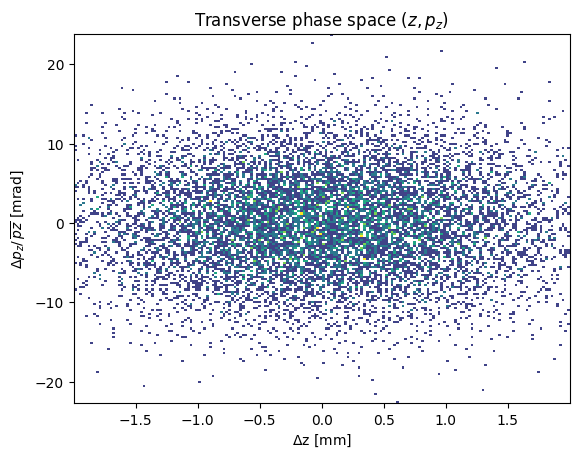

In [65]:
fig, ax = plt.subplots()

momenta = pz/np.mean(pz) 
valid = np.logical_and(-1e2 < momenta, momenta < 1e2)

ax.hist2d(z[valid], momenta[valid], (180, 180), cmap=white_viridis)
ax.title.set_text(r'Transverse phase space $(z, p_z)$')
ax.set_xlabel(r'$\Delta $z [mm]'); ax.set_ylabel(r'$\Delta p_z/\,\overline{pz}$ [mrad]')

plt.show()

In [66]:
np.mean(pz)

247.11510870290155

# Emittance

In [67]:
def emittance(coordinates, momentum):
    moment_coordinates = np.mean(coordinates**2) - np.mean(coordinates)**2
    moment_momentum = np.mean(momentum**2) - np.mean(momentum)**2
    moment_mixed = np.mean(coordinates*momentum) - np.mean(coordinates)*np.mean(momentum)
    
    return np.sqrt(moment_coordinates * moment_momentum - moment_mixed**2)

In [68]:
emittance_x = np.pi * emittance(x, px/np.mean(pz))
emittance_x 

6.496418932815118

In [69]:
emittance_y = np.pi/np.mean(pz) * emittance(y, py)
emittance_y 

6.496418932815138

# Simulation Request

In [81]:
cavity_table = pd.read_csv("./data/cavity_E_field.dat", names=['z', 'v'], sep=" ")
bucking_table = pd.read_csv("./data/bucking_B_field.dat", names=['z', 'v'], sep=" ")
main_table = pd.read_csv("./data/main_B_field.dat", names=['z', 'v'], sep=" ")
solenoid_table = pd.read_csv("./data/solenoid_B_field.dat", names=['z', 'v'], sep=" ")

In [82]:
bucking_table

,z,v
0,-0.500,-0.000139
1,-0.495,-0.000144
2,-0.490,-0.000150
3,-0.485,-0.000156
4,-0.480,-0.000162
...,...,...
196,0.480,-0.000044
197,0.485,-0.000043
198,0.490,-0.000042
199,0.495,-0.000041


In [83]:
generator_parameters['time_spread'] = True
response = request("generate", generator_parameters)
response.status_code

200

In [84]:
parsed_response = response.json()
distribution_timestamp = parsed_response['timestamp']
distribution_timestamp

'1707304614.613133'

In [114]:
solenoid_table

,z,v
0,-0.50000,0.000302
1,-0.49625,0.000304
2,-0.49250,0.000307
3,-0.48875,0.000309
4,-0.48500,0.000311
...,...,...
396,0.98500,0.000569
397,0.98875,0.000560
398,0.99250,0.000551
399,0.99625,0.000543


In [249]:
body = { 
    'run_specs': {
        'particle_file_name': distribution_timestamp,
        'rms_laser_spot_size': 0.1,
    },
    'space_charge': {
        'use_space_charge': True,
        'z_trans': 0.1
    },
    'cavities': [
        {'phase': 90, 'z_0': 0.0, 'field_table': cavity_table.to_dict('list')},
    ],
    'solenoids': [
        {
            'field_table': solenoid_table.to_dict('list'), 
            'max_field_strength': solenoid_table.max()['v']
        },
    ]
}

In [250]:
response = request("simulate", body)
response.status_code

200

In [251]:
parsed_response = response.json()
print(parsed_response['input_ini'])

&NEWRUN
    Version = 4
    Head = 'Simulation run at time 13:17:02 date 2024-02-07'
    RUN = 1
    Qbunch = 0.1
    Q_Schottky = 0.0
    XYrms = 0.1
    Trms = -1.0
    H_min = 0.0
    H_max = 0.001
    Max_step = 100000
    Z_Cathode = 0.0
    Track_All = true
    Auto_Phase = true
    Distribution = '/app/data/generator/1707304614.613133.ini'
/

&OUTPUT
    ZSTART = 0.0
    ZSTOP = 1.0
    Zemit = 100
    Zphase = 1
    High_res = true
    RefS = true
    EmitS = true
    Tr_emitS = true
    PhaseS = true
/

&CHARGE
    LSPCH = true
    z_trans = 0.1
    Lmirror = true
    Nrad = 32
    Cell_var = 2.0
    Max_Scale = 0.05
    Max_Count = 40
    Exp_Control = 0.1
    L2D_3D = true
/

&CAVITY
    LEfield = true

    Nue(1) = 1.3
    C_pos(1) = 0.0
    C_smooth(1) = 10
    C_higher_order(1) = true
    Phi(1) = 90.0
    MaxE(1) = 130.0
    File_Efield(1) = 'C1_E.dat'
/

&SOLENOID
    LBfield = true

    S_smooth(1) = 10
    MaxB(1) = 0.1798372446609468
    File_Bfield(1) = 'S1_B.dat'
/

In [252]:
parsed_response = response.json()
print(parsed_response['run_output'])

 --------------------------------------------------------------------------

               Astra - A space charge tracking algorithm 
                             Version 4.0              
                         DESY,  Hamburg 2022          
                          7. 2.2024  16: 7

     Parameter file is:  /app/data/simulation/1707322037.005009/run.in     
     Simulation run at time 13:17:02 date 2024-02-07                                 

 Initialize element settings:
 --------------------------------------------------------------------------
 Cavity:

     Reading cavity field data from:      C1_E.dat                                                                        
     field smoothing is applied
     Cavity Frequency               f =    1.300     GHz
     maximum gradient                      130.0     MV/m
     at                                    0.000     m
     estimated average gradient            57.43     MV/m
     nominal phase                         90.00 

In [253]:
data = pd.DataFrame(parsed_response['particles'])

x = data.loc[:, 'x'].values*1e3
y = data.loc[:, 'y'].values*1e3
z = data.loc[:, 'z'].values*1e3
px = data.loc[:, 'px'].values
py = data.loc[:, 'py'].values
pz = data.loc[:, 'pz'].values

data

,x,y,z,px,py,pz,clock,macro_charge,particle_index,status_flag
0,-0.000006,0.000018,1.014038,-4.666694,31.335133,1.128525e+06,3.685980,-0.00001,1,5
1,-0.000018,-0.000030,0.016572,-277.219107,-969.496881,1.452074e+05,0.000500,-0.00001,1,3
2,0.001812,0.002928,-0.023598,2486.445506,4576.549767,-1.503722e+05,-0.000500,-0.00001,1,3
3,0.000968,0.001372,0.026959,995.207744,1659.507730,2.631074e+05,0.001000,-0.00001,1,3
4,-0.000927,0.002221,-0.055952,-1016.700159,1849.507596,-2.959368e+05,-0.001000,-0.00001,1,3
...,...,...,...,...,...,...,...,...,...,...
9995,0.000145,0.001387,-0.135627,-7.241814,1457.187458,-5.165782e+05,-0.001832,-0.00001,1,5
9996,-0.000216,0.000134,0.040064,-296.033881,286.037587,4.583254e+05,0.002151,-0.00001,1,5
9997,-0.000032,0.000826,0.012761,-147.920255,2570.645563,1.078616e+05,0.000387,-0.00001,1,5
9998,-0.005180,0.001569,-0.019794,-8180.544322,2016.207490,-1.291849e+05,-0.000476,-0.00001,1,5


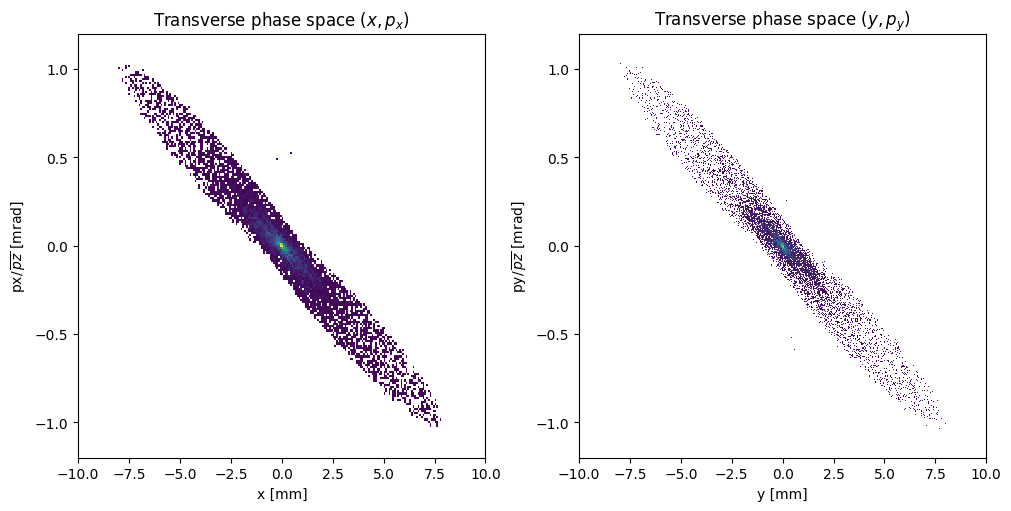

In [255]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

bins = 500
x_lim = 10
y_lim = 1.2

ax_1.hist2d(x, px/np.mean(pz), (bins, bins), cmap=white_viridis)
ax_1.title.set_text(r'Transverse phase space $(x, p_x)$')
ax_1.set_xlabel('x [mm]'); ax_1.set_ylabel(r'px/$\,\overline{pz}$ [mrad]')
ax_1.set_xlim(left=-x_lim, right=x_lim)
ax_1.set_ylim(bottom=-y_lim, top=y_lim)

ax_2.hist2d(y, py/np.mean(pz), (bins, bins), cmap=white_viridis)
ax_2.title.set_text(r'Transverse phase space $(y, p_y)$')
ax_2.set_xlabel('y [mm]'); ax_2.set_ylabel(r'py/$\,\overline{pz}$ [mrad]')
ax_2.set_xlim(left=-x_lim, right=x_lim)
ax_2.set_ylim(bottom=-y_lim, top=y_lim)

plt.show()

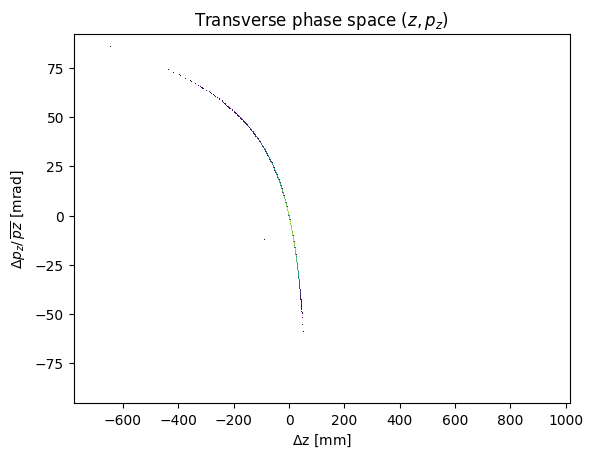

In [247]:
fig, ax = plt.subplots()

bins = 500
momenta = pz/np.mean(pz) 
valid = np.logical_and(-1e2 < momenta, momenta < 1e2)

ax.hist2d(z[valid], momenta[valid], (bins, bins), cmap=white_viridis)
ax.title.set_text(r'Transverse phase space $(z, p_z)$')
ax.set_xlabel(r'$\Delta $z [mm]'); ax.set_ylabel(r'$\Delta p_z/\,\overline{pz}$ [mrad]')

plt.show()